# Imports, loading features and DB

In [1]:
import sys; sys.path.insert(0, '..')
from database.dataset import *

from general_utils.plots import plot_bboxes_over_image, simple_im_show, simple_im_show2, plot_froc
from metrics.metrics import get_tp_fp_fn, quick_circle_comparison, circle_comparison

from metrics.metrics import get_froc
import matplotlib.pyplot as plt

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    # to deal include big clusters
    max_lesion_diam_mm=1000000.,
    partitions=['train', 'validation'],
    extract_patches=False,
    min_breast_fraction_roi=0.5,
    normalize=None,
    n_jobs=-1,
)

# Classification

In [3]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import f1_score, roc_auc_score, auc

from sklearn.preprocessing import MinMaxScaler


from sklearn.discriminant_analysis import  LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

In [4]:
features_data = pd.read_pickle('allfs_10000maxlessize_hough2.pkl')

print(features_data.shape)
features_data.head()

(188908, 123)


img_energy img_entropy img_uniformity   img_min img_10th_perc img_90th_perc  \
0  75.167207    7.321293       0.006664   0.46431      0.503199      0.702862   
1  89.631071    7.053286       0.008434  0.607744       0.63771      0.710438   
2  87.744642     7.23831       0.007185  0.601684      0.621717      0.710606   
3  82.826999     6.63184       0.011506  0.616498      0.633333       0.66532   
4  99.314361    6.832448       0.009788  0.657239      0.689226      0.738384   

    img_max  img_mean img_median img_inter_quartile_range  ...  \
0  0.736364  0.614775   0.631481                 0.134259  ...   
1   0.73569  0.675713   0.675589                 0.039731  ...   
2  0.750842   0.66823   0.672391                 0.053451  ...   
3  0.684848  0.649948   0.650842                 0.017003  ...   
4  0.754209   0.71158   0.709428                 0.028788  ...   

  patch_glcm_contrast_HL1_0 patch_glcm_contrast_HH1_0  \
0                  0.169031                 -0.110529   
1                  0.169031                 -0.064028   
2                  0.169031                  -0.02994   
3                  0.169031                 -0.173099   
4                  0.169031                  0.061251   

  patch_glcm_dissimilarity_LH1_0 patch_glcm_dissimilarity_HL1_0  \
0                       0.006134                         8109.8   
1                       0.002443                    8349.628571   
2                        0.01601                         7423.0   
3                       0.001408                    8437.885714   
4                       0.037194                    5536.542857   

  patch_glcm_dissimilarity_HH1_0 candidate_coordinates  \
0                      66.257143      [1042, 2295, 11]   
1                           72.6      [1272, 1605, 19]   
2                      71.514286       [1071, 747, 19]   
3                      73.942857       [877, 1666, 19]   
4                      59.857143      [1039, 1740, 19]   

              patch_coordinates center_patch_mask_intersection  \
0  ((2288, 2302), (1035, 1049))                             49   
1  ((1598, 1612), (1265, 1279))                              0   
2    ((740, 754), (1064, 1078))                              0   
3    ((1659, 1673), (870, 884))                              0   
4  ((1733, 1747), (1032, 1046))                              0   

  whole_patch_intersection    img_id  
0                      156  20586908  
1                        0  20586908  
2                        0  20586908  
3                        0  20586908  
4                        0  20586908  

[5 rows x 123 columns]

### TO DO:

**I. Cascade Classification**
1. Which features/classifiers are better to use on what stage. We'd like to know wich quick feature set can reduce number of candidates with retaining high sensitivity so we can in the next steps of cascade use more features (more complex ones) for detection?
    1. Feature extraction time by type
    2. False postivie reduction power with a goal for retaining 0.99 sensitivity

2. Build the cascaded classification. Show FP reduction and sensitivity changes of each step of cascade. Make it parametrized.
    1. Check if there is a point in using a cumulative set of features or only the new one.
    2. Check feature importances for each step of cascade.

3. Do hard negative mining. Use pool of negative samples to mine hard ones for every step of cascade training to get more robust classifiers.


**II. All features together Classification**

In [5]:
from xgboost import XGBRFClassifier

In [14]:
# retrieving each features set column names

fos_cols = [x for x in features_data if 'img' in x and x != 'img_id']
gabor_cols = [x for x in features_data if 'gabor_'in x]
wavelet_cols = [x for x in features_data if  x[:6] == 'patch_' and x != 'patch_coordinates']
haar_cols = [x for x in features_data if  'haar' in x]
features_sets = {'fos':fos_cols, 'gabor':gabor_cols, 'wavelet':wavelet_cols, 'haar': haar_cols, 'fos+gabor+wavelet+haar':fos_cols+gabor_cols+wavelet_cols+haar_cols}


In [15]:
# adding case_id column
imgid2caseid = db.df[['img_id', 'case_id']].set_index('img_id').to_dict()['case_id']
features_data['case_id'] = [imgid2caseid[imgid] for imgid in features_data['img_id']]

### FIX 1
Dropping hough2 duplicates

In [16]:
features_data_conv2str = features_data.drop(columns=features_sets['fos+gabor+wavelet+haar']).astype(str)
print(len(features_data_conv2str))
print(len(features_data_conv2str.drop_duplicates()))
features_data = features_data[~features_data_conv2str.duplicated()]

### FIX 2
Considering original mask intersection

NOT A GOOD IDEA, IGNORE THIS CELL FOR NOW

In [17]:
# features_data['raw_mask_intersection'] = 0
# for img_id in tqdm(db.df.img_id.unique()):
#     raw_mask = cv2.imread(str(db.full_mask_path/f'{img_id}_lesion_mask.png'), cv2.IMREAD_GRAYSCALE)
#     for idx, row in features_data[features_data.img_id == img_id].iterrows():
#         (ppx1, ppx2), (ppy1, ppy2)= row['patch_coordinates']
#         features_data.at[idx, 'raw_mask_intersection'] = (raw_mask[ppx1:ppx2, ppy1:ppy2]>0).sum()

In [18]:
features_data

img_energy img_entropy img_uniformity   img_min img_10th_perc  \
0    75.167207    7.321293       0.006664   0.46431      0.503199   
1    89.631071    7.053286       0.008434  0.607744       0.63771   
2    87.744642     7.23831       0.007185  0.601684      0.621717   
3    82.826999     6.63184       0.011506  0.616498      0.633333   
4    99.314361    6.832448       0.009788  0.657239      0.689226   
..         ...         ...            ...       ...           ...   
882  59.062474    6.715842       0.011193  0.514886      0.526795   
883   50.50374    6.766863       0.010308  0.473205      0.482837   
884  49.866857    6.242357       0.015983  0.476357      0.491944   
885  61.010924    6.537303       0.012182  0.532399      0.542032   
886  73.845258    6.538653       0.012703  0.579685      0.597198   

    img_90th_perc   img_max  img_mean img_median img_inter_quartile_range  \
0        0.702862  0.736364  0.614775   0.631481                 0.134259   
1        0.710438   0.73569  0.675713   0.675589                 0.039731   
2        0.710606  0.750842   0.66823   0.672391                 0.053451   
3         0.66532  0.684848  0.649948   0.650842                 0.017003   
4        0.738384  0.754209   0.71158   0.709428                 0.028788   
..            ...       ...       ...        ...                      ...   
882      0.576883  0.603853  0.548606    0.54641                 0.025306   
883       0.53275  0.552715  0.507264    0.50718                 0.034413   
884      0.516637  0.535902  0.504305   0.503678                  0.01331   
885       0.57338  0.593345  0.557793   0.557268                 0.016462   
886      0.636953  0.662347  0.613608   0.610683                  0.01944   

     ... patch_glcm_contrast_HH1_0 patch_glcm_dissimilarity_LH1_0  \
0    ...                 -0.110529                       0.006134   
1    ...                 -0.064028                       0.002443   
2    ...                  -0.02994                        0.01601   
3    ...                 -0.173099                       0.001408   
4    ...                  0.061251                       0.037194   
..   ...                       ...                            ...   
882  ...                 -0.267399                        0.03068   
883  ...                 -0.335174                       0.030143   
884  ...                  0.039102                       0.029861   
885  ...                  0.129686                       0.008663   
886  ...                 -0.083861                       0.002252   

    patch_glcm_dissimilarity_HL1_0 patch_glcm_dissimilarity_HH1_0  \
0                           8109.8                      66.257143   
1                      8349.628571                           72.6   
2                           7423.0                      71.514286   
3                      8437.885714                      73.942857   
4                      5536.542857                      59.857143   
..                             ...                            ...   
882                   12517.857143                      95.171429   
883                    9620.628571                      82.628571   
884                    7653.742857                      69.971429   
885                    6927.228571                      65.171429   
886                    6504.571429                           62.4   

    candidate_coordinates             patch_coordinates  \
0        [1042, 2295, 11]  ((2288, 2302), (1035, 1049))   
1        [1272, 1605, 19]  ((1598, 1612), (1265, 1279))   
2         [1071, 747, 19]    ((740, 754), (1064, 1078))   
3         [877, 1666, 19]    ((1659, 1673), (870, 884))   
4        [1039, 1740, 19]  ((1733, 1747), (1032, 1046))   
..                    ...                           ...   
882         [416, 625, 3]      ((618, 632), (409, 423))   
883         [658, 458, 3]      ((451, 465), (651, 665))   
884       [1401, 1700, 3]  ((1693, 1707), (1394, 1408))   
88

100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


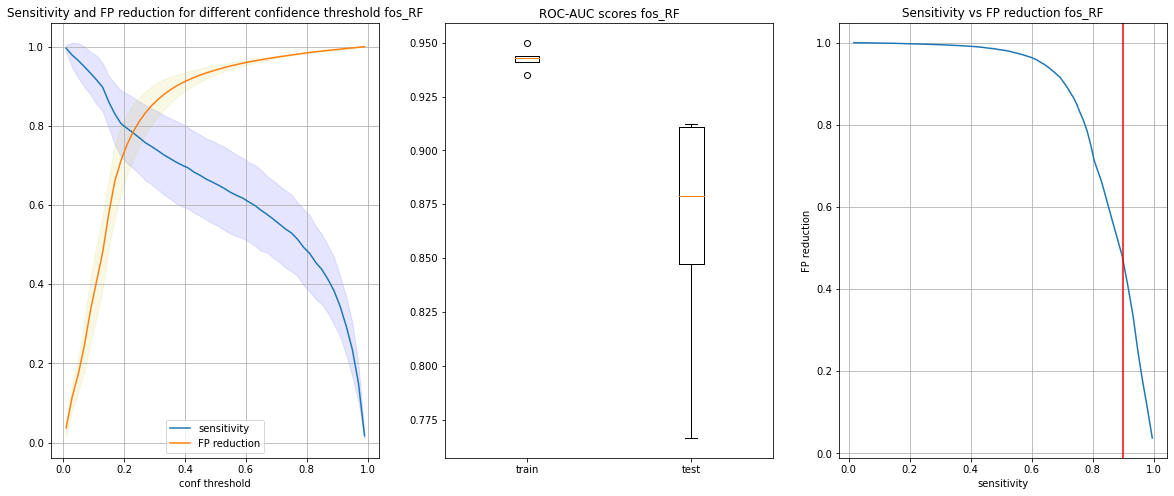

100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


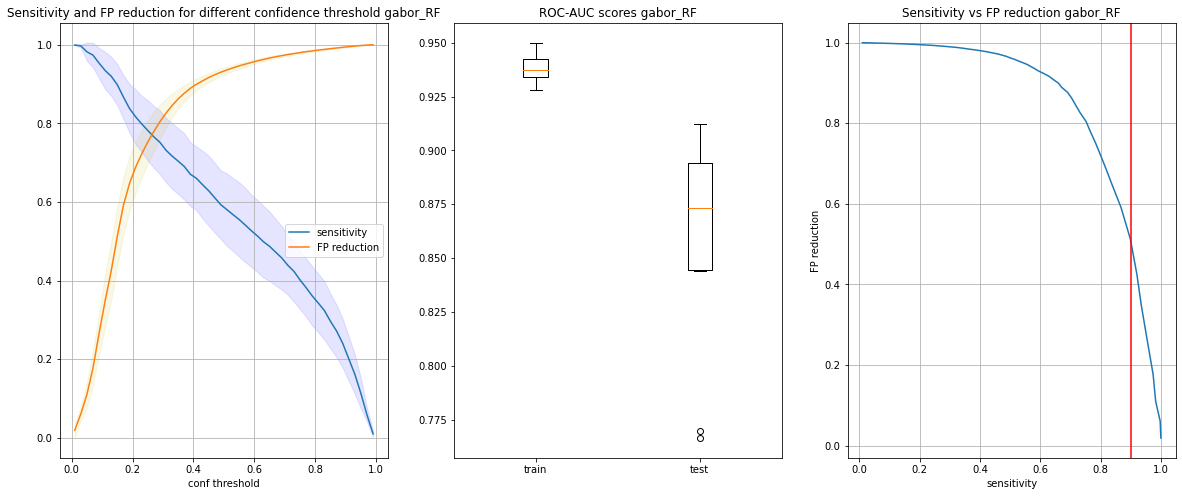

100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


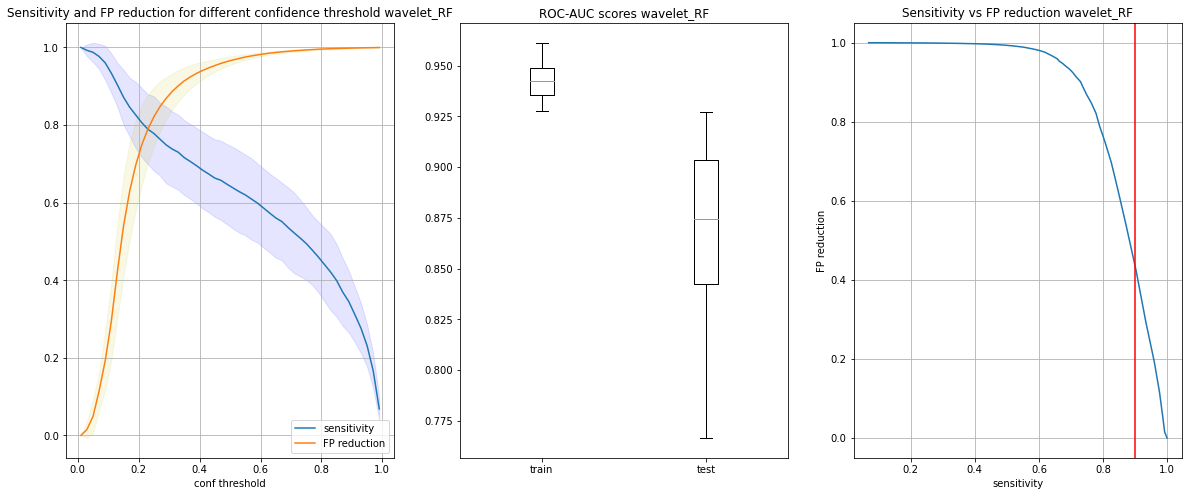

100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


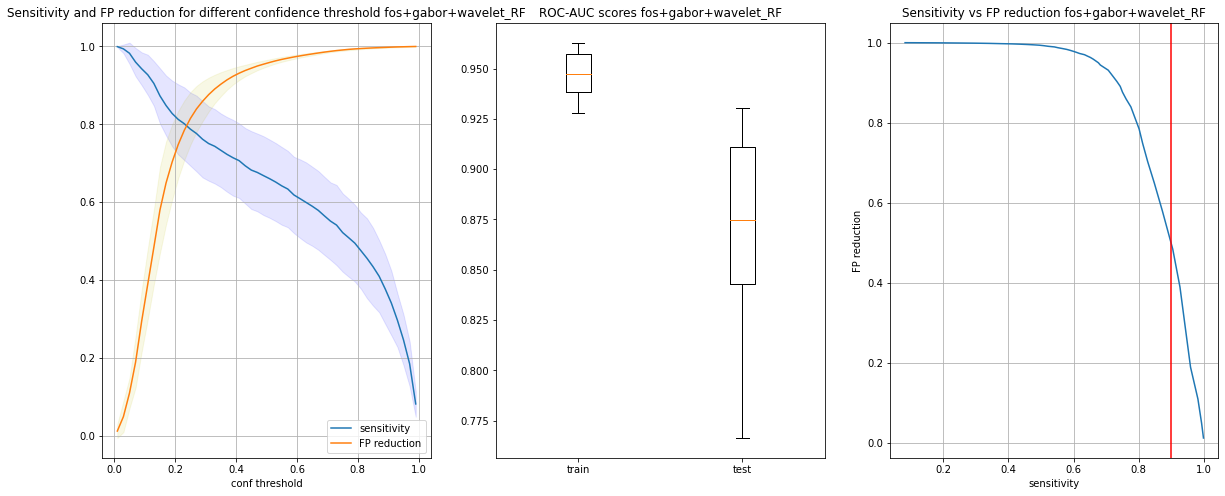

In [19]:
kfolds = 5
FP2TP_rate = 2
desired_sensitivity = 0.9

conf_thresholds = np.linspace(0.01, 0.99)

# splitting data into train/validation case-wise
all_case_ids = features_data.case_id.unique()
kfolds_case_splits = np.array_split(all_case_ids, kfolds)

# masking bad positives (with mC not in the center of the patch) (now they are good positives so nvm)
# bad_positives_mask = (features_data.center_patch_mask_intersection == 0) & (features_data.whole_patch_intersection > 0)


roc_aucs = []

# need to add SVC but a fast implementation or just wait a lot
classifiers = {'XGBRF': XGBRFClassifier(n_estimators=100, max_depth=8, n_jobs=-1),
               'RF': RandomForestClassifier(n_estimators=100, max_depth=8, n_jobs=-1)}

# classifiers = {'RF': RandomForestClassifier(n_estimators=100, max_depth=8, n_jobs=-1)}

results = {}

for feature_set_name, features_set in features_sets.items():

    for clf_name, clf in classifiers.items():
        
        fpr_sens_curve = []

        # kfold CV
        for valid_case_ids in tqdm(kfolds_case_splits):

            # split data into test
            test_split_mask = features_data.case_id.isin(valid_case_ids)
            
            # split into train and take into account cleaned data with no mC in the borders of the patch
            cleaned_features_data = features_data[~test_split_mask]
            
            # and sampling to a predefined 1:FP2TP_rate TP:FP samples
            positive_mask = (cleaned_features_data.whole_patch_intersection>0)
            positive_train_part = cleaned_features_data[positive_mask]
            negative_train_part = cleaned_features_data[~positive_mask].sample(FP2TP_rate*positive_mask.sum()) # INGORING SAMPLING
            
            train_df = pd.concat([positive_train_part, negative_train_part]).sample(frac=1.)
            
            
            
            test_df = features_data[test_split_mask]
            
            train_y = (train_df['whole_patch_intersection'] > 0).astype(bool)
            test_y = (test_df['whole_patch_intersection'] > 0).astype(bool)
            
            scaler = MinMaxScaler()
            train_X_scaled = scaler.fit_transform(train_df[features_set].values)
            test_X_scaled = scaler.transform(test_df[features_set].values)
            
            clf.fit(train_X_scaled, train_y)

            train_y_predicted = clf.predict_proba(train_X_scaled)[:,1]
            test_y_predicted = clf.predict_proba(test_X_scaled)[:,1]
            
            roc_aucs.append((roc_auc_score(train_y, train_y_predicted),
                            roc_auc_score(test_y, test_y_predicted)))
            
            sens_fpr = []
            for pred_thr in conf_thresholds:
                test_y_pred_binarized = (test_y_predicted>pred_thr).astype(bool)
                TP = (test_y & test_y_pred_binarized).sum()
                FN = (test_y & ~test_y_pred_binarized).sum()
                FP = (~test_y & test_y_pred_binarized).sum()
                max_FP_possible = (~test_y).sum()
                sens = TP/(TP + FN)
                sens_fpr.append((sens, 1 - FP/max_FP_possible))
                
            fpr_sens_curve.append(sens_fpr)

        # mean and std batch-wise of fpr and sensitivity
        fpr_sens_curve_mean = np.asarray(fpr_sens_curve).mean(axis=0)
        fpr_sens_curve_std = np.asarray(fpr_sens_curve).std(axis=0)


        fig, axs = plt.subplots(1, 3, figsize=(20, 8))

        axs[0].plot(conf_thresholds, fpr_sens_curve_mean[:,0])
        axs[0].fill_between(conf_thresholds, (fpr_sens_curve_mean[:,0]-fpr_sens_curve_std[:,0]), (fpr_sens_curve_mean[:,0]+fpr_sens_curve_std[:,0]), color='b', alpha=.1)

        axs[0].plot(conf_thresholds, fpr_sens_curve_mean[:,1])
        axs[0].fill_between(conf_thresholds, (fpr_sens_curve_mean[:,1]-fpr_sens_curve_std[:,1]), (fpr_sens_curve_mean[:,1]+fpr_sens_curve_std[:,1]), color='y', alpha=.1)

        axs[0].legend(['sensitivity', 'FP reduction'])
        axs[0].grid()
        axs[0].set_xlabel('conf threshold')
        axs[0].set_title(f'Sensitivity and FP reduction for different confidence threshold {feature_set_name}_{str(clf_name)}')

        axs[1].set_title(f'ROC-AUC scores {feature_set_name}_{str(clf_name)}')
        axs[1].boxplot(np.array(roc_aucs), labels=['train', 'test'])

        axs[2].plot(fpr_sens_curve_mean[:,0], fpr_sens_curve_mean[:,1])
        axs[2].set_xlabel('sensitivity')
        axs[2].set_ylabel('FP reduction')
        axs[2].set_title(f'Sensitivity vs FP reduction {feature_set_name}_{str(clf_name)}')
        axs[2].axvline(desired_sensitivity, c='r')
        axs[2].grid()

        plt.show()
        
        results[f'{feature_set_name}_{str(clf_name)}'] = fpr_sens_curve_mean


FP reduction show how many of the FP candidates were classified as negatives (aka reduction of FP)

### Final comparison graph

Text(0, 0.5, 'FP reduction')

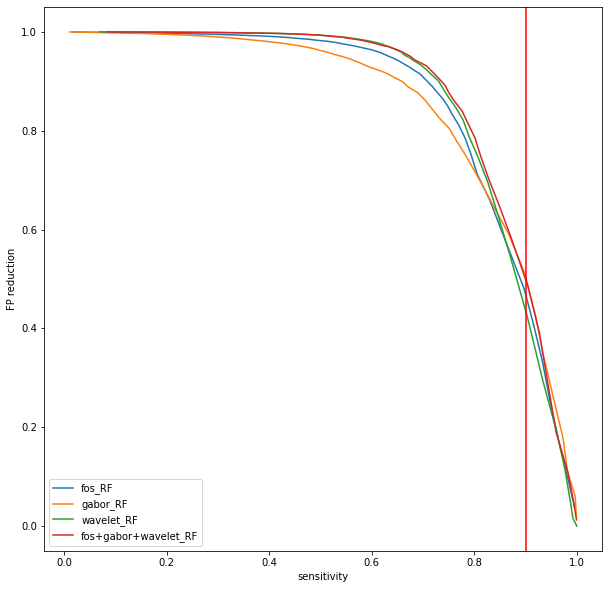

In [20]:
plt.figure(figsize=(10,10))

for fs, fs_res in results.items():
    plt.plot(fs_res[:,0], fs_res[:,1])

plt.axvline(desired_sensitivity, c='r')
plt.legend(results.keys())
plt.xlabel('sensitivity')
plt.ylabel('FP reduction')


## FROC Curve and final Metrics

In [24]:
FP2TP_rate = 2
features_set = features_sets['fos+gabor+wavelet']

In [25]:
train_img_ids = db.df[db.df.partition == 'train'].img_id.values
validation_img_ids = db.df[db.df.partition == 'validation'].img_id.values


final_clf = XGBRFClassifier(n_estimators=100, max_depth=8, n_jobs=-1)

# split data into test
test_split_mask = features_data.img_id.isin(validation_img_ids)

# split into train and take into account cleaned data with no mC in the borders of the patch
cleaned_features_data = features_data[~test_split_mask]

# and sampling to a predefined 1:FP2TP_rate TP:FP samples
positive_mask = (cleaned_features_data.whole_patch_intersection>0)
positive_train_part = cleaned_features_data[positive_mask]
negative_train_part = cleaned_features_data[~positive_mask].sample(FP2TP_rate*positive_mask.sum()) # INGORING SAMPLING

print(f'FP:TP rate: {len(negative_train_part)/len(positive_train_part)}:1')

train_df = pd.concat([positive_train_part, negative_train_part]).sample(frac=1.)

test_df = features_data[test_split_mask]

train_y = (train_df['whole_patch_intersection'] > 0).astype(bool)
test_y = (test_df['whole_patch_intersection'] > 0).astype(bool)

scaler = MinMaxScaler()
train_X_scaled = scaler.fit_transform(train_df[features_set].values)
test_X_scaled = scaler.transform(test_df[features_set].values)

clf.fit(train_X_scaled, train_y)

train_y_predicted = clf.predict_proba(train_X_scaled)[:,1]
test_y_predicted = clf.predict_proba(test_X_scaled)[:,1]


train_df['confidence'] = train_y_predicted
test_df['confidence'] = test_y_predicted

FP:TP rate: 2.0:1


/tmp/ipykernel_662088/1743277647.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['confidence'] = test_y_predicted


In [26]:
test_df_conv_str = test_df.drop(columns=features_set).astype(str)
test_df_conv_str.drop_duplicates()

candidate_coordinates           patch_coordinates  \
0        [ 343 1225   19]  ((1218, 1232), (336, 350))   
1        [ 278 1191   19]  ((1184, 1198), (271, 285))   
2        [ 353 1202   19]  ((1195, 1209), (346, 360))   
3           [ 93 645  19]     ((638, 652), (86, 100))   
4        [ 265 1209   19]  ((1202, 1216), (258, 272))   
..                    ...                         ...   
735      [ 429 1096    3]  ((1089, 1103), (422, 436))   
736      [ 495 1205    3]  ((1198, 1212), (488, 502))   
737      [ 107 2021    2]  ((2014, 2028), (100, 114))   
738      [ 411 2329    2]  ((2322, 2336), (404, 418))   
739      [ 783 1664    2]  ((1657, 1671), (776, 790))   

    center_patch_mask_intersection whole_patch_intersection    img_id  \
0                                0                        0  20587148   
1                                0                        0  20587148   
2                                0                        0  20587148   
3                                0                        0  20587148   
4                                0                        0  20587148   
..                             ...                      ...       ...   
735                              0                        0  24065761   
736                              0                        0  24065761   
737                              0                        0  24065761   
738                              0                        0  24065761   
739                              0                        0  24065761   

              case_id            confidence  
0    fd746d25eb40b3dc   0.33831761263284826  
1    fd746d25eb40b3dc   0.15900641194261436  
2    fd746d25eb40b3dc    0.1258120523484343  
3    fd746d25eb40b3dc    0.1616894796326968  
4    fd746d25eb40b3dc   0.17933599573996242  
..                ...                   ...  
735  5291e1aee2bbf5df   0.07555450931066915  
736  5291e1aee2bbf5df  0.034150879494572496  
737  5291e1aee2bbf5df   0.14200720607097075  
738  5291e1aee2bbf5df    0.1921282171839243  
739  5291e1aee2bbf5df   0.30701744010629517  

[51327 rows x 7 columns]

100%|██████████| 118/118 [00:55<00:00,  2.14it/s]


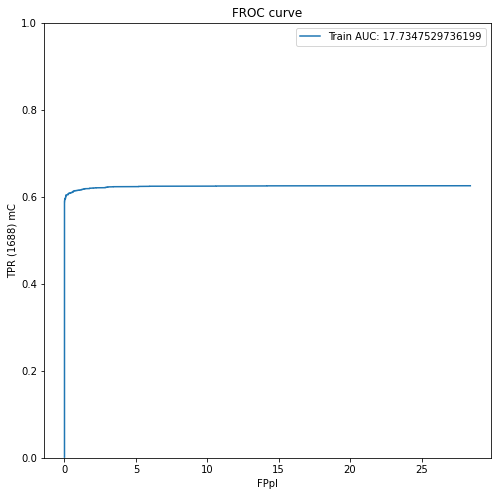

100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


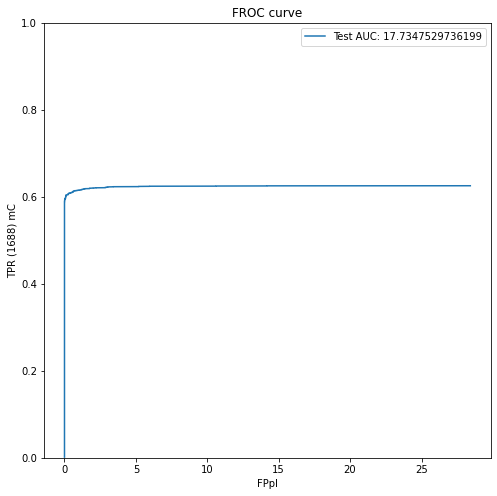

In [28]:
fpis_train, tprs_train, froc_aggr_all_df_train, total_mC_train = get_froc(train_df, db, 14) # 14 instead of 7 to consider whole_patch_intersection
plot_froc(fpis_train, tprs_train, total_mC_train, label='Train')

fpis_test, tprs_test, froc_aggr_all_df_test, total_mC_test = get_froc(test_df, db, 14)
plot_froc(fpis_train, tprs_train, total_mC_train, label='Test')

### Problems
1. ~~Duplicates in candidates, why?~~
2. Loss of labels in masks (including origianl masks) -> 22670177_lesion_mask.png
3. ~~Not properly saved labels in INBreast db from original mask (present in original not in one from the class) -> 20587174~~
4. ~~Mask labels are not exactly in the center of the patch (even though the mC is in the center, labeled roi is shifted) ->20587466~~
5. Pectoral muscle segmentation??? Some weird lines detection -> 22670147

In [29]:
test_res_df = froc_aggr_all_df_test.drop(columns=features_set)
bad_test_res_df = test_res_df[test_res_df.label =='FP']
bad_test_res_df_str = test_res_df[test_res_df.label =='FP']
bad_test_res_df_str.candidate_coordinates = bad_test_res_df_str.candidate_coordinates.apply(str)
bad_test_res_df_str.patch_coordinates = bad_test_res_df_str.patch_coordinates.apply(str)
bad_test_res_df = bad_test_res_df[~bad_test_res_df_str.duplicated()]

print(len(bad_test_res_df), len(bad_test_res_df_str))

49696 49696


/home/vzalevskyi/anaconda3/envs/calc_det/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [30]:
bad_test_res_df.head(40)

candidate_coordinates             patch_coordinates  \
634          [395, 1289, 9]    ((1282, 1296), (388, 402))   
30898      [1353, 1422, 17]  ((1415, 1429), (1346, 1360))   
38182        [333, 2316, 6]    ((2309, 2323), (326, 340))   
34708         [904, 105, 5]       ((98, 112), (897, 911))   
34683          [767, 28, 6]        ((21, 35), (760, 774))   
29686        [322, 2904, 7]    ((2897, 2911), (315, 329))   
7676        [1341, 2888, 4]  ((2881, 2895), (1334, 1348))   
32274      [1386, 2995, 12]  ((2988, 3002), (1379, 1393))   
35050         [772, 196, 4]      ((189, 203), (765, 779))   
34586         [560, 36, 16]        ((29, 43), (553, 567))   
34773          [511, 14, 5]         ((7, 21), (504, 518))   
29793        [730, 2741, 7]    ((2734, 2748), (723, 737))   
34836          [512, 57, 6]        ((50, 64), (505, 519))   
8435         [297, 669, 17]      ((662, 676), (290, 304))   
656         [271, 1559, 18]    ((1552, 1566), (264, 278))   
29333       [1372, 3061, 8]  ((3054, 3068), (1365, 1379))   
43051         [469, 513, 9]      ((506, 520), (462, 476))   
27855        [33, 2206, 12]      ((2199, 2213), (26, 40))   
35225         [1088, 42, 3]      ((35, 49), (1081, 1095))   
34923         [841, 135, 5]      ((128, 142), (834, 848))   
24147        [951, 2029, 9]    ((2022, 2036), (944, 958))   
20135      [1225, 1498, 19]  ((1491, 1505), (1218, 1232))   
36394          [1, 1996, 5]       ((1989, 2003), (0, 14))   
26681       [1220, 2335, 9]  ((2328, 2342), (1213, 1227))   
34313      [1125, 2065, 14]  ((2058, 2072), (1118, 1132))   
25655        [91, 2041, 12]      ((2034, 2048), (84, 98))   
48743          [9, 134, 13]         ((127, 141), (2, 16))   
21425       [854, 1371, 13]    ((1364, 1378), (847, 861))   
15662       [853, 2077, 17]    ((2070, 2084), (846, 860))   
50179        [290, 2148, 5]    ((2141, 2155), (283, 297))   
25585         [726, 803, 9]      ((796, 810), (719, 733))   
35642         [60, 131, 13]        ((124, 138), (53, 67))   
34872          [345, 45, 6]        ((38, 52), (338, 352))   
36863        [138, 171, 16]      ((164, 178), (131, 145))   
35011         [959, 146, 3]      ((139, 153), (952, 966))   
9246          [301, 315, 8]      ((308, 322), (294, 308))   
35111           [2, 275, 3]         ((268, 282), (0, 14))   
28781        [970, 1817, 7]    ((1810, 1824), (963, 977))   
11638       [581, 2140, 17]    ((2133, 2147), (574, 588))   
3314        [426, 1117, 13]    ((1110, 1124), (419, 433))   

       center_patch_mask_intersection  whole_patch_intersection    img_id  \
634                                 0                         0  20587174   
30898                               0                         0  24055328   
38182                               0                         0  24055806   
34708                               0                         0  24055725   
34683                               0                         0  24055725   
29686                               0                         0  24055274   
7676                                0                         0  20588536   
32274                               0                         0  24055355   
35050                               0                         0  24055725   
34586                               0                         0  24055725   
34773                               0                         0  24055725   
29793                               0                         0  24055274   
34836                               0                         0  24055725   
8435                                0                         0  20588562   
656                                 0                         0  20587174   
29333                               0                         0  24055274   
43051                               0                         0  24058712   
27855                               0                         0  22670978   
35225                               0    

 19%|█▉        | 19/100 [00:42<02:52,  2.13s/it]/tmp/ipykernel_617110/4219991142.py:13: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  axs[didx, 0].imshow(test_img[ppx1-delta:ppx2+delta,  ppy1-delta:ppy2+delta], cmap='gray')
/tmp/ipykernel_617110/4219991142.py:17: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  axs[didx, 1].imshow(test_mask[ppx1-delta:ppx2+delta, ppy1-delta:ppy2+delta], cmap='gray')
/tmp/ipykernel_617110/4219991142.py:21: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  axs[didx, 2].imshow(original_test_mask[ppx1-delta:ppx2+delta, ppy1-delta:ppy2+delta]>0, cmap='gray')
 20%|██        | 20/100 [00:44<02:38,  1.98s/it]/tmp/ipykernel_617110/4219991142.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the

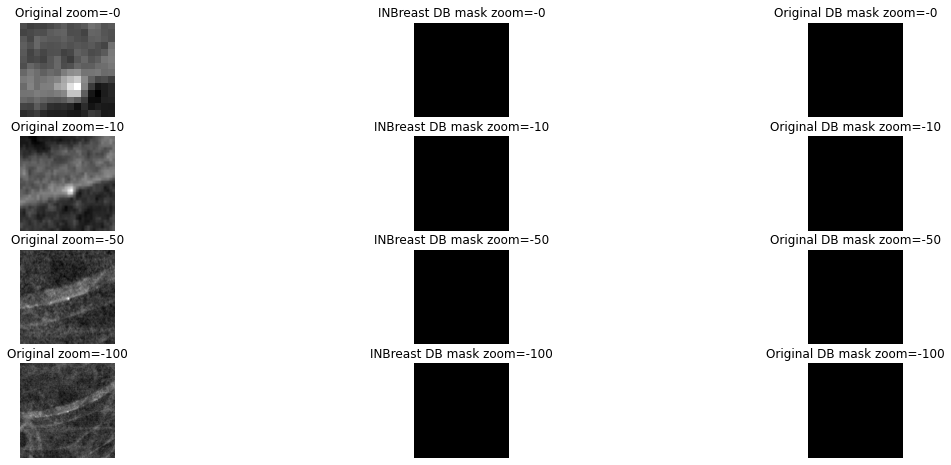

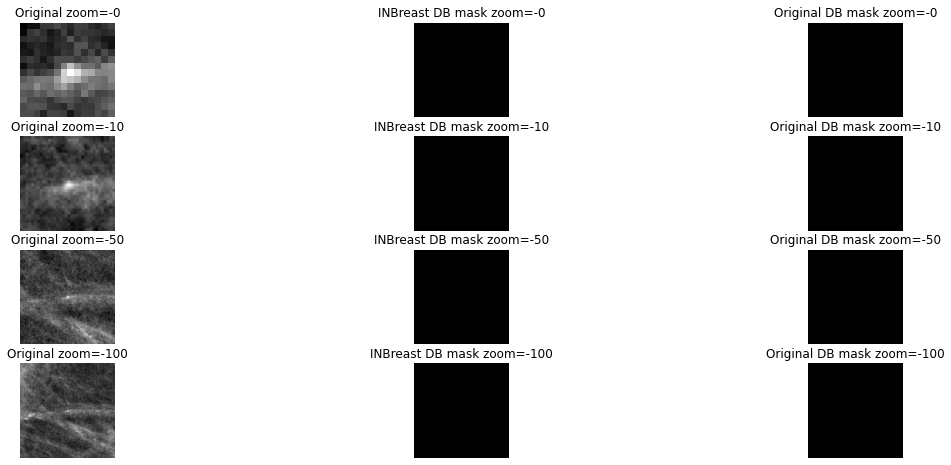

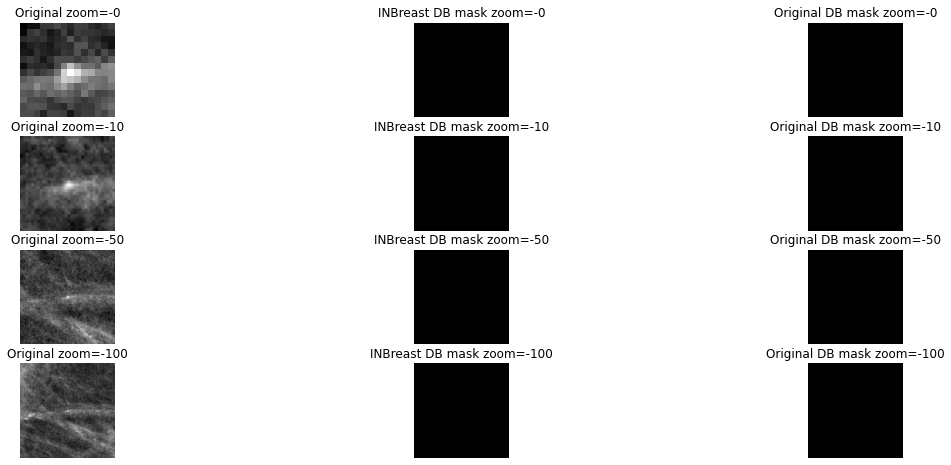

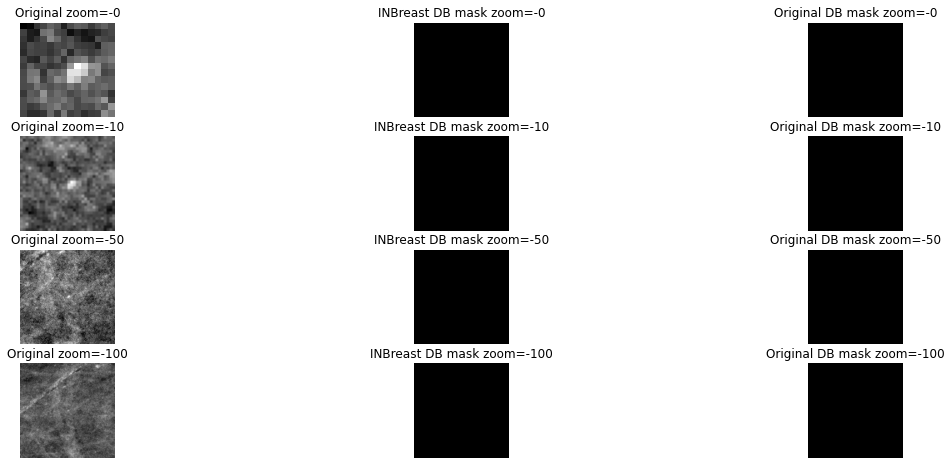

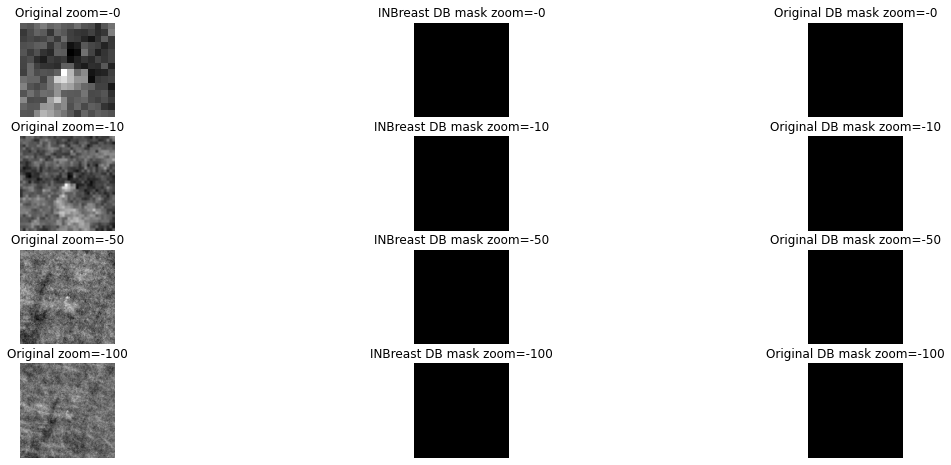

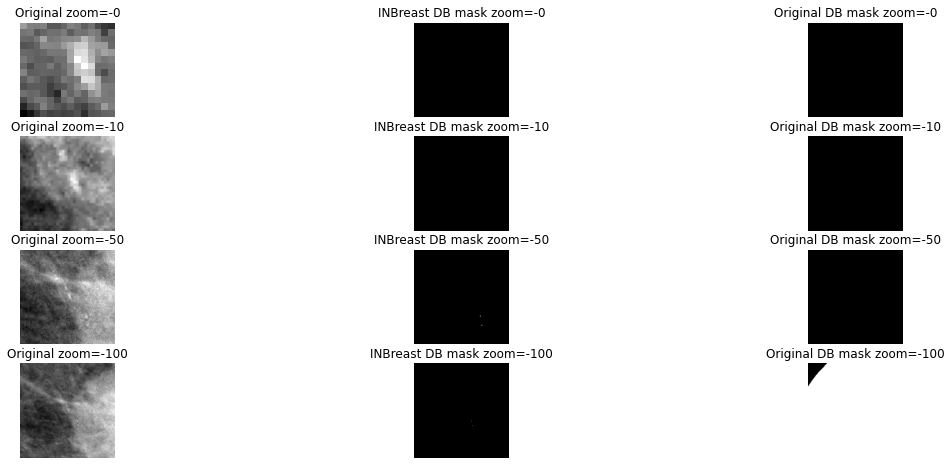

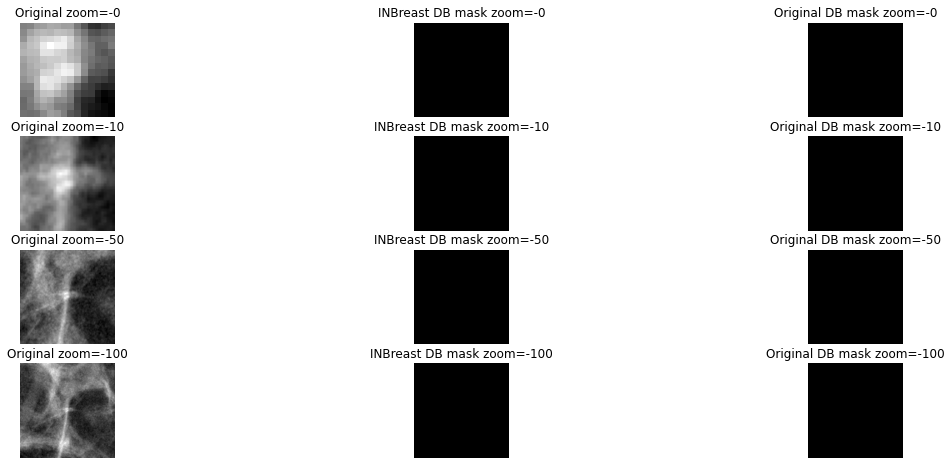

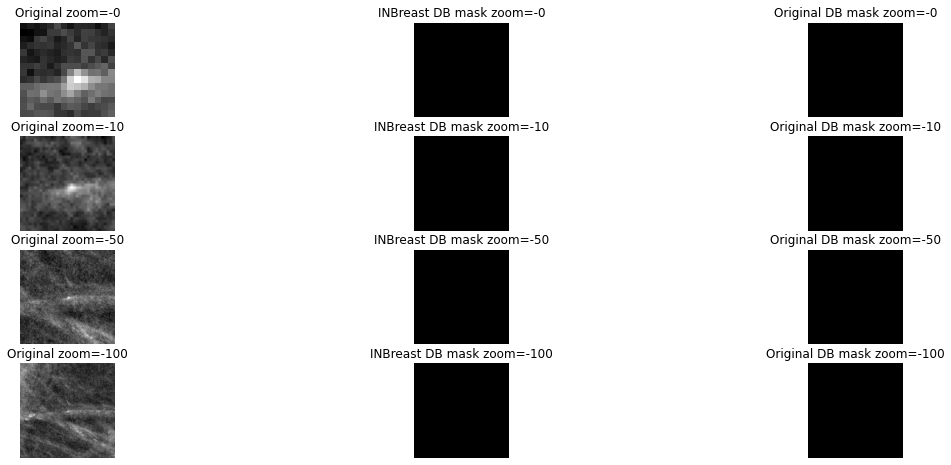

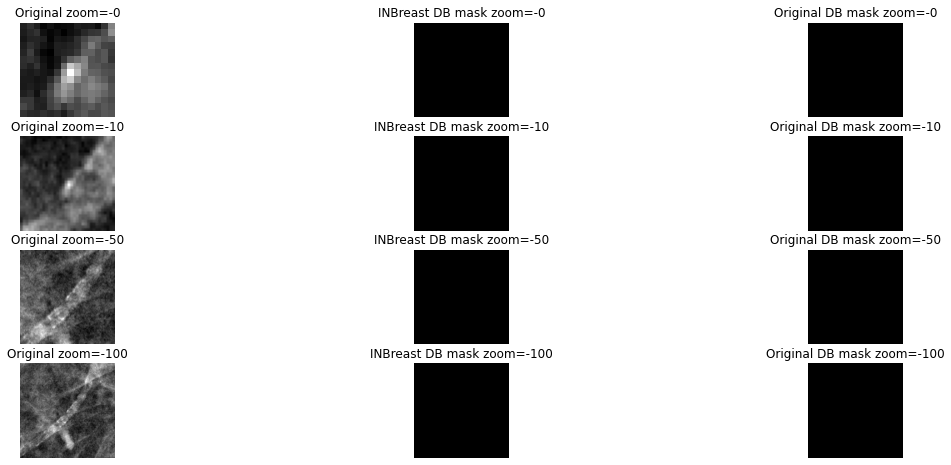

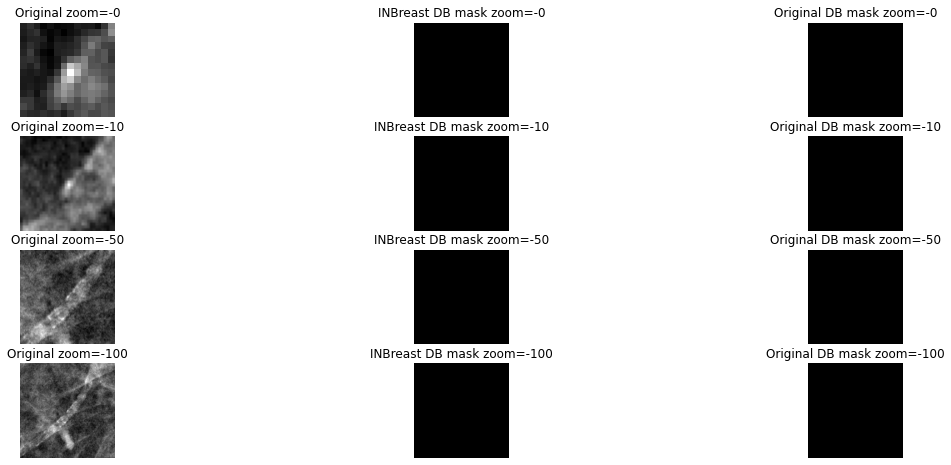

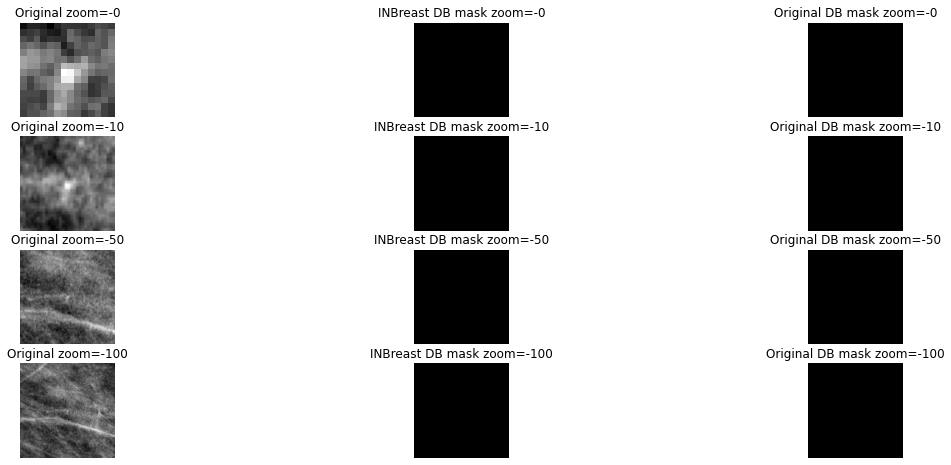

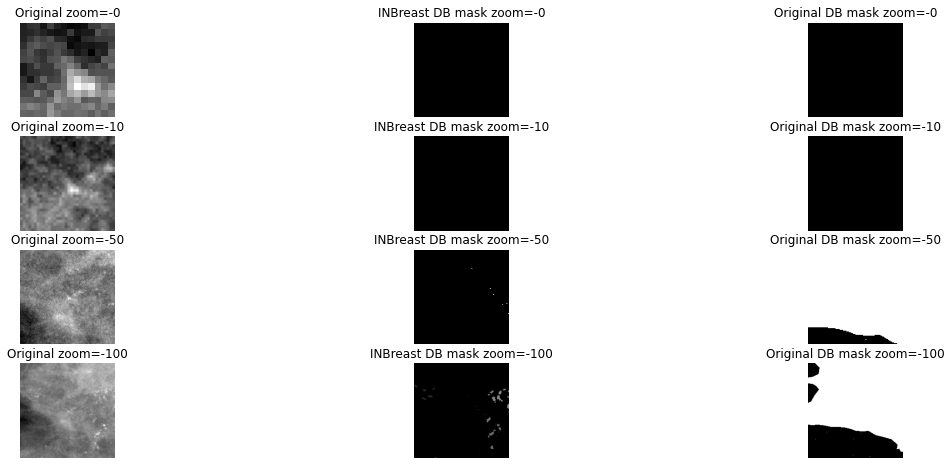

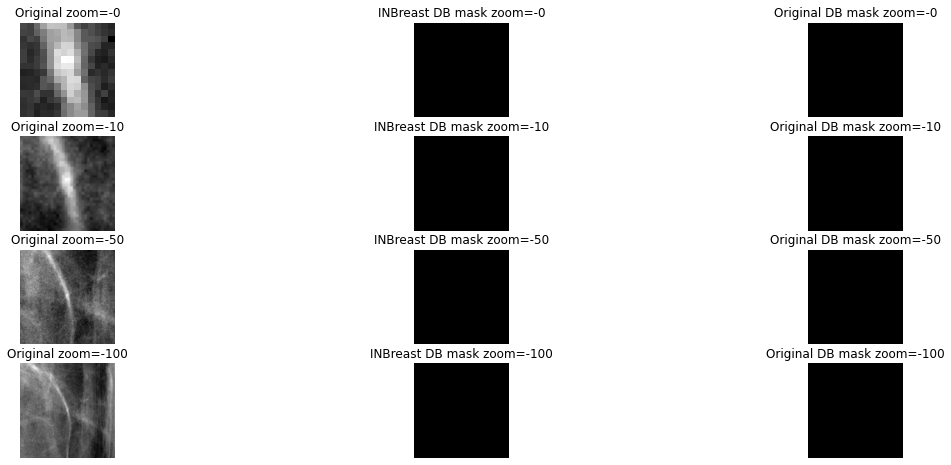

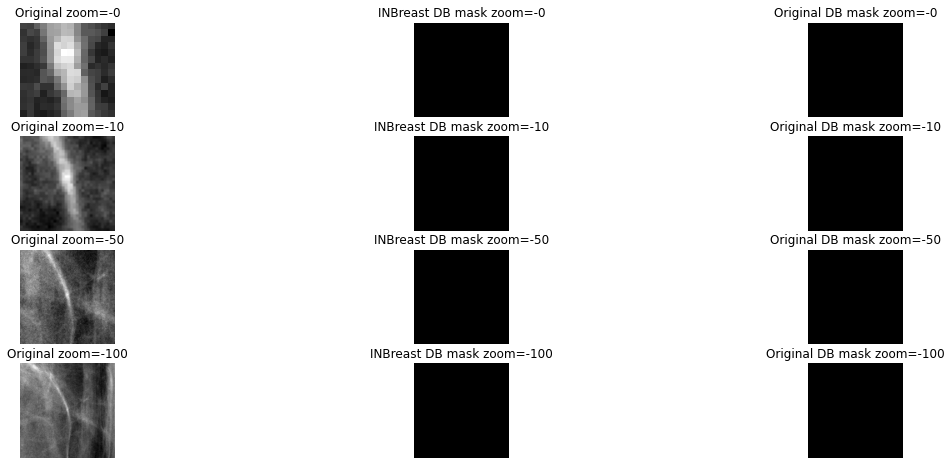

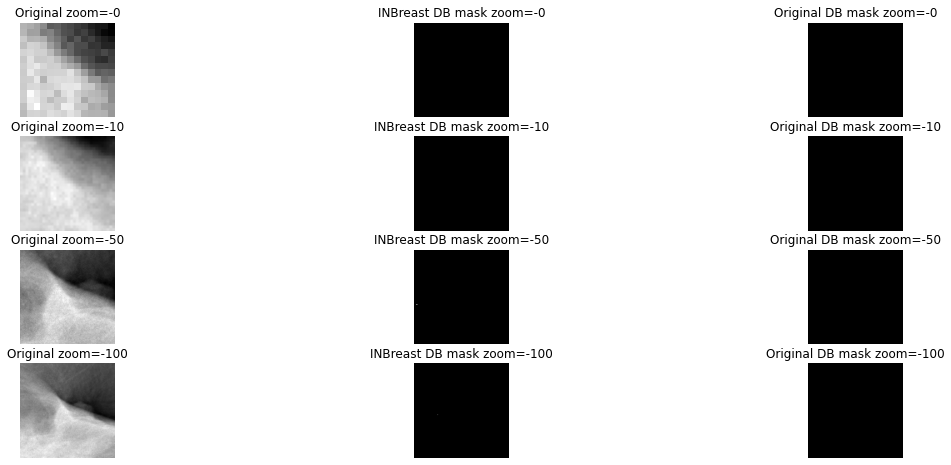

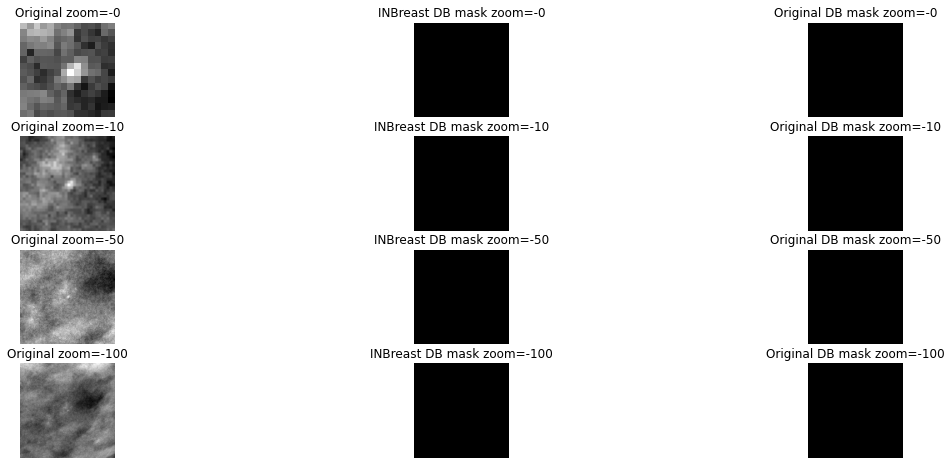

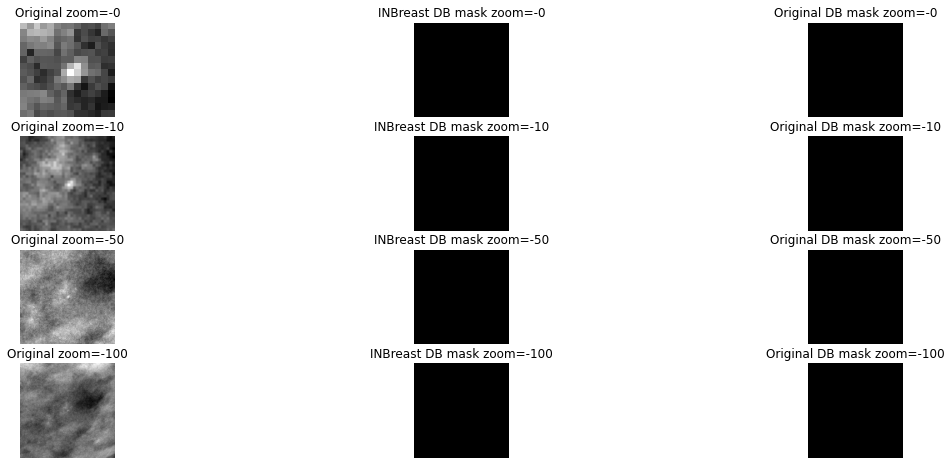

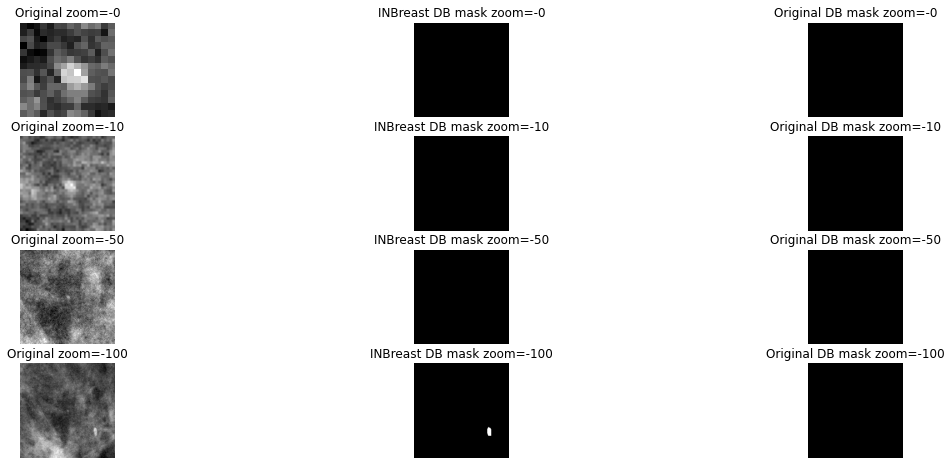

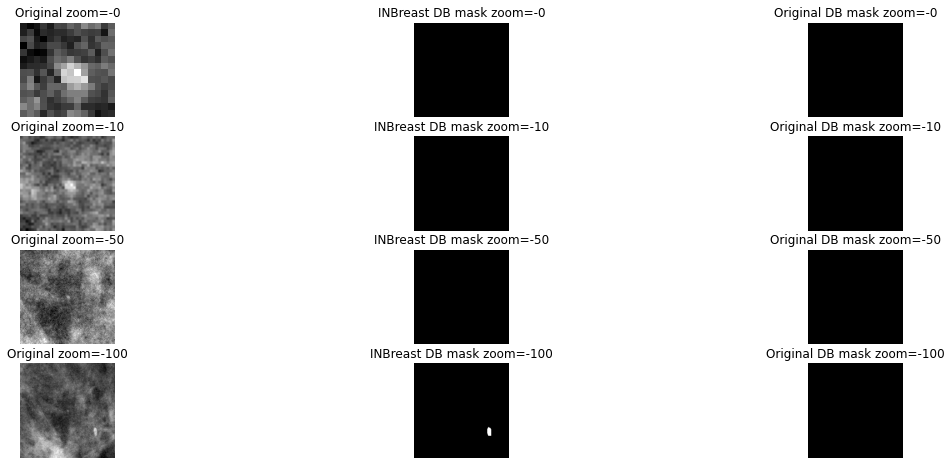

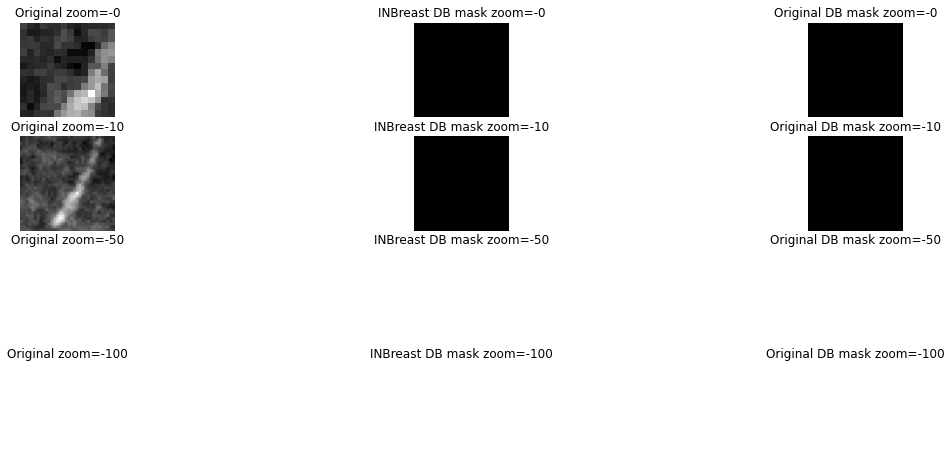

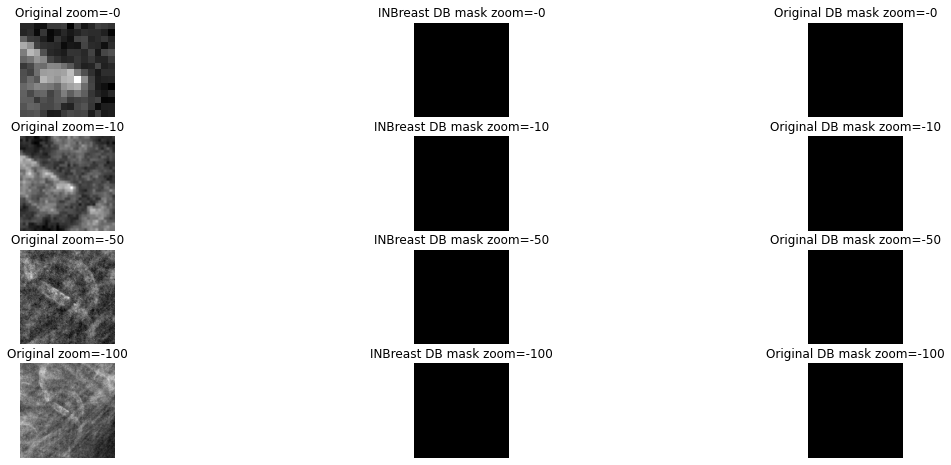

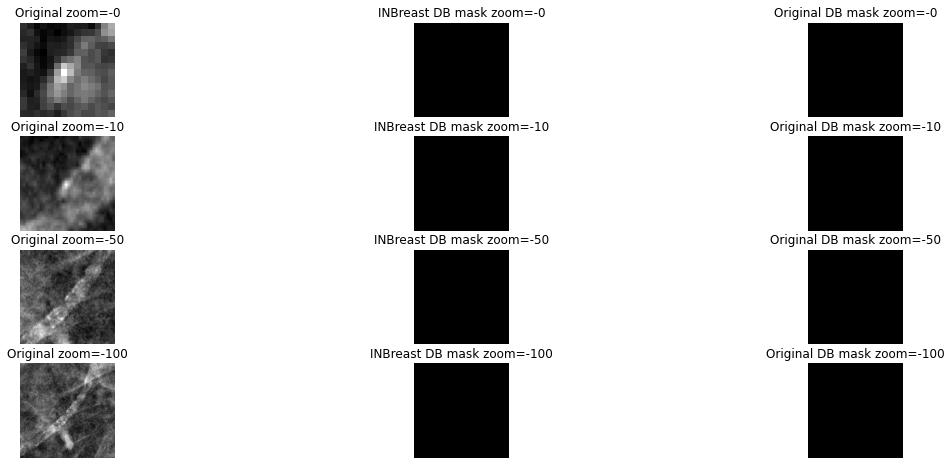

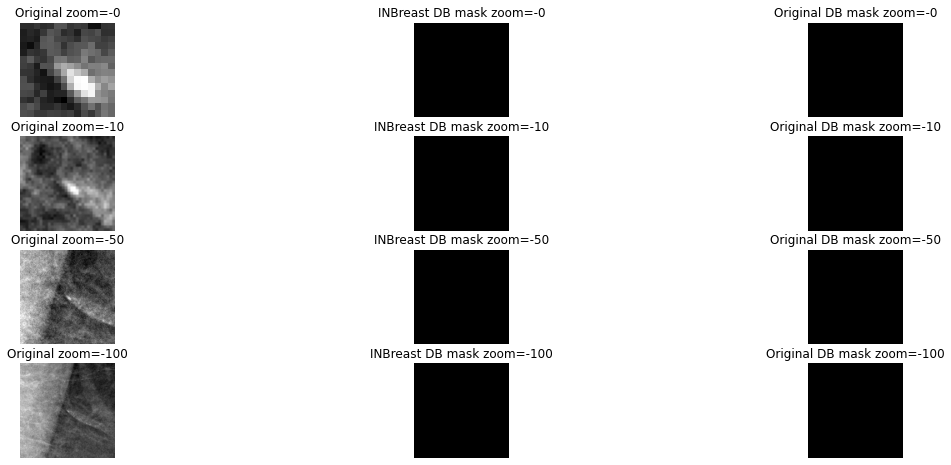

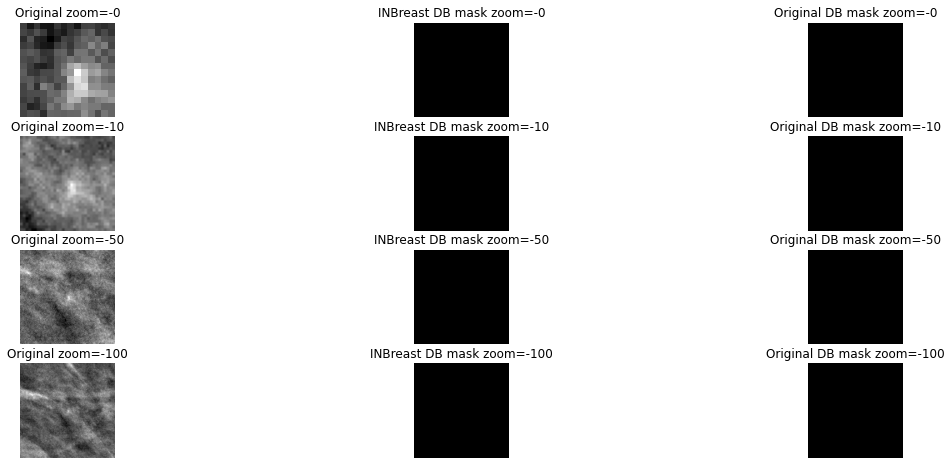

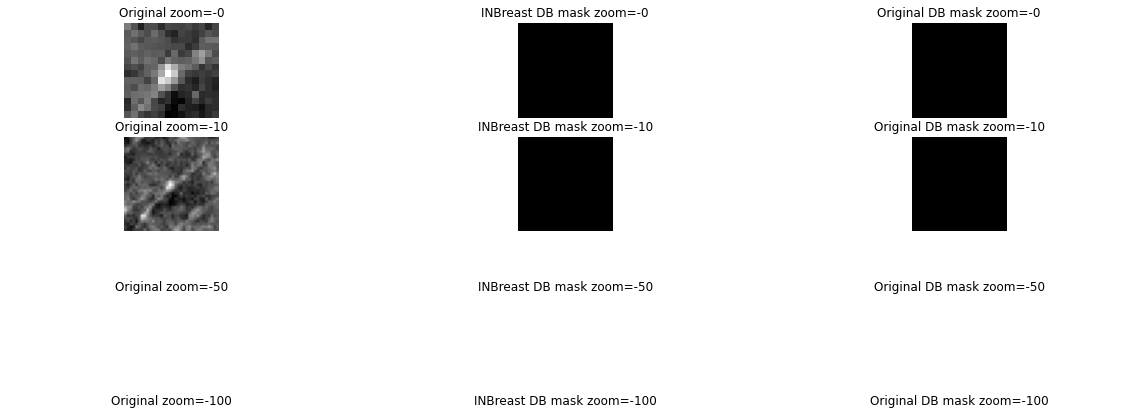

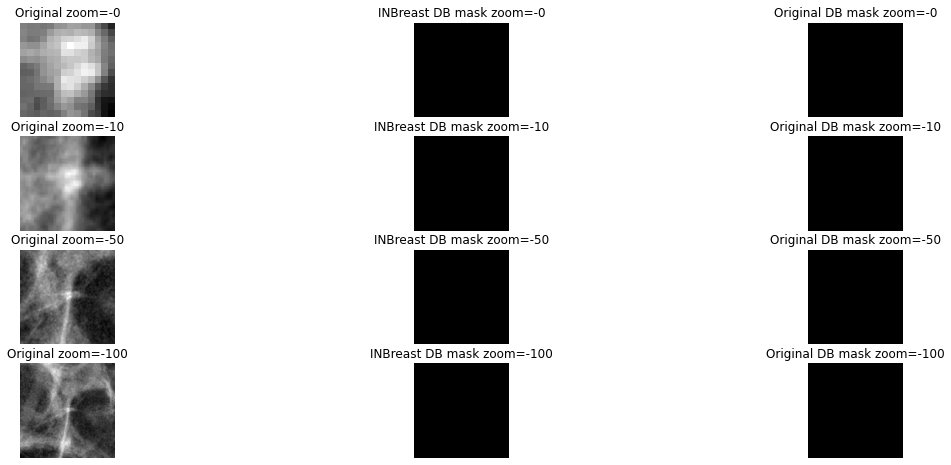

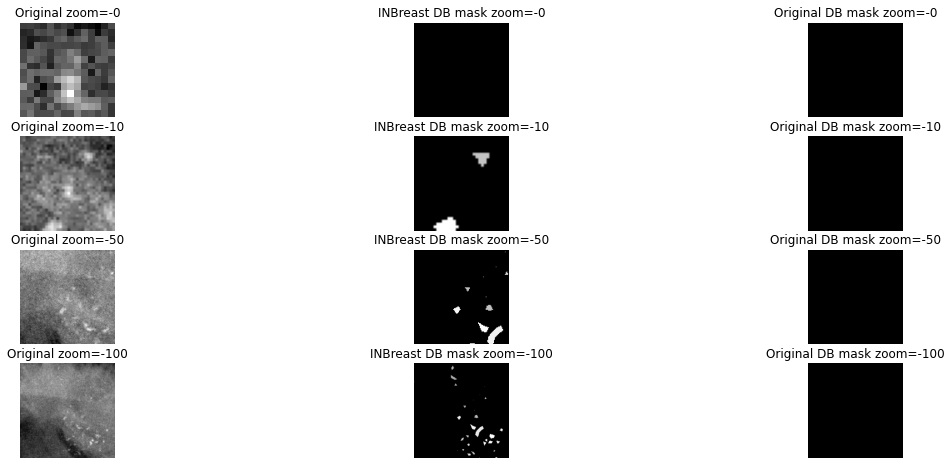

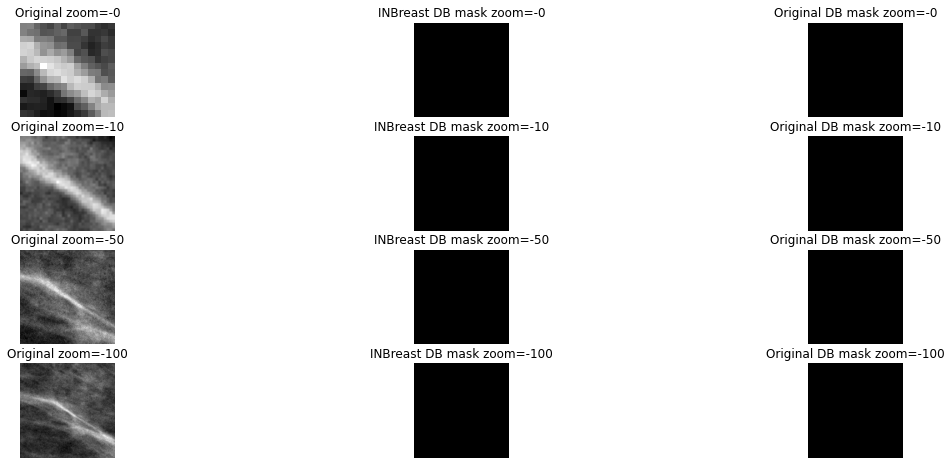

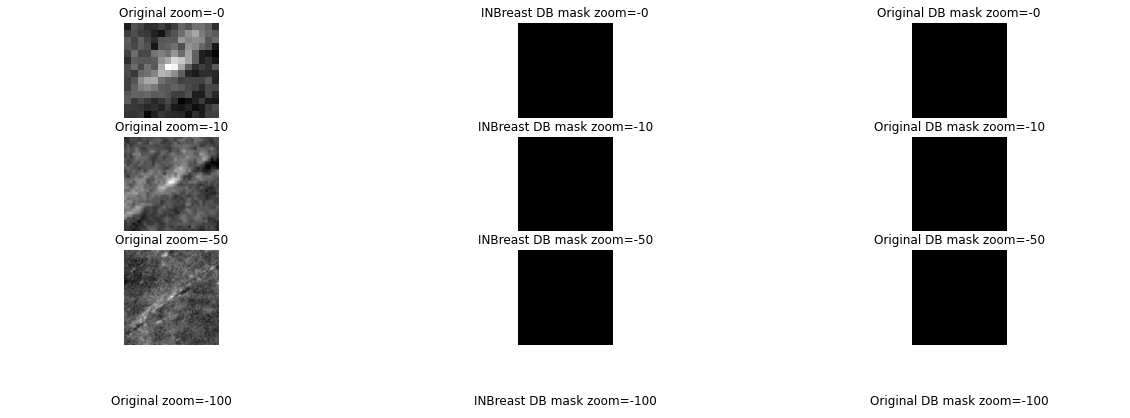

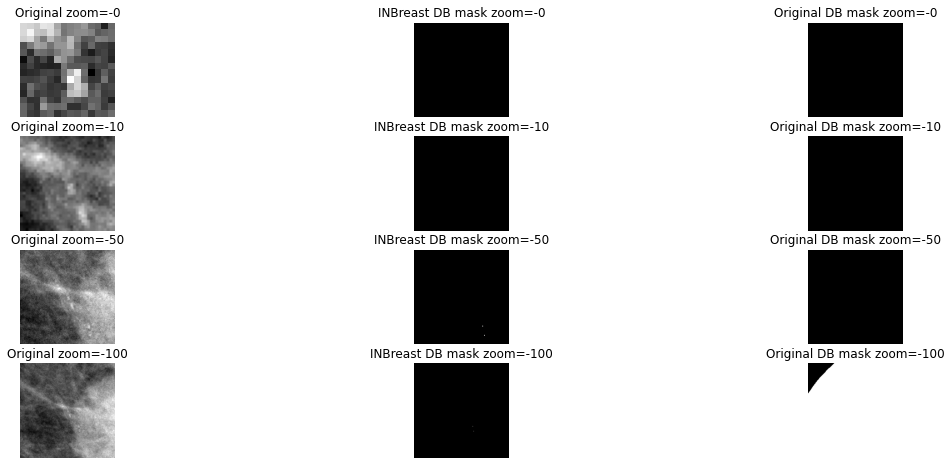

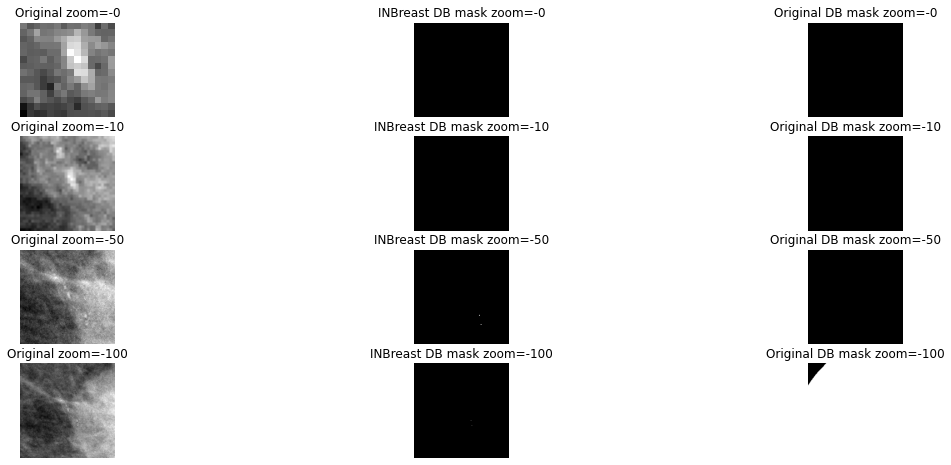

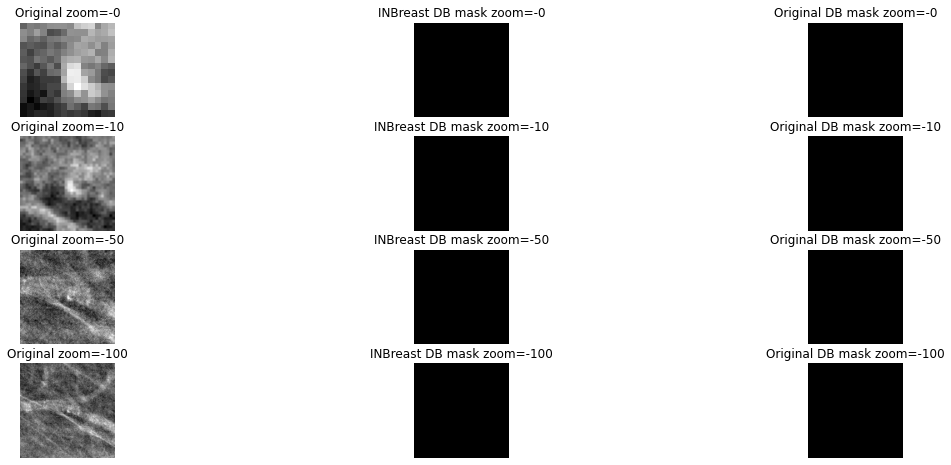

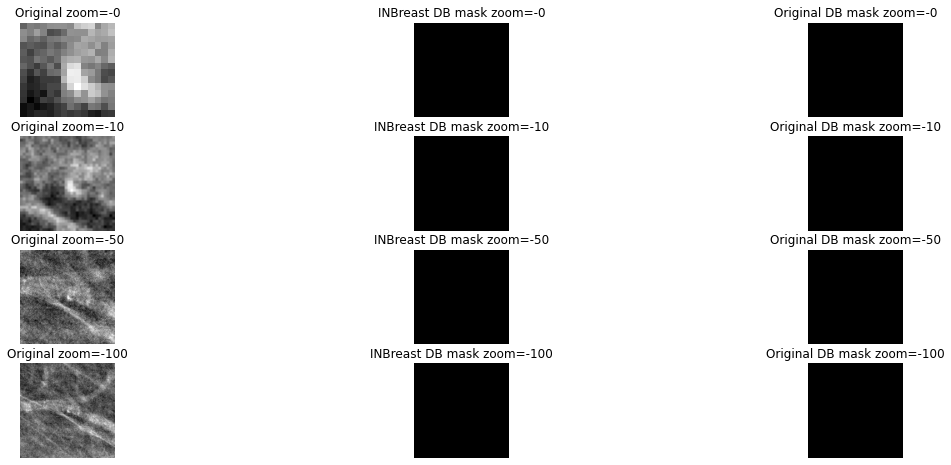

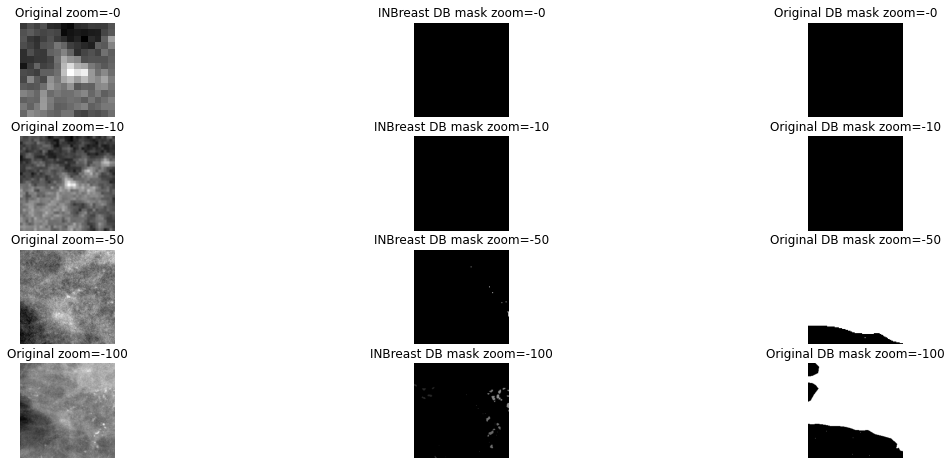

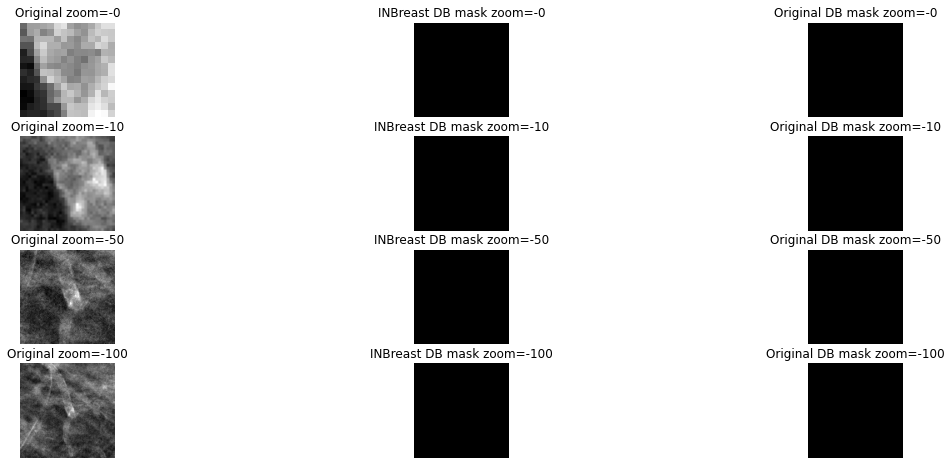

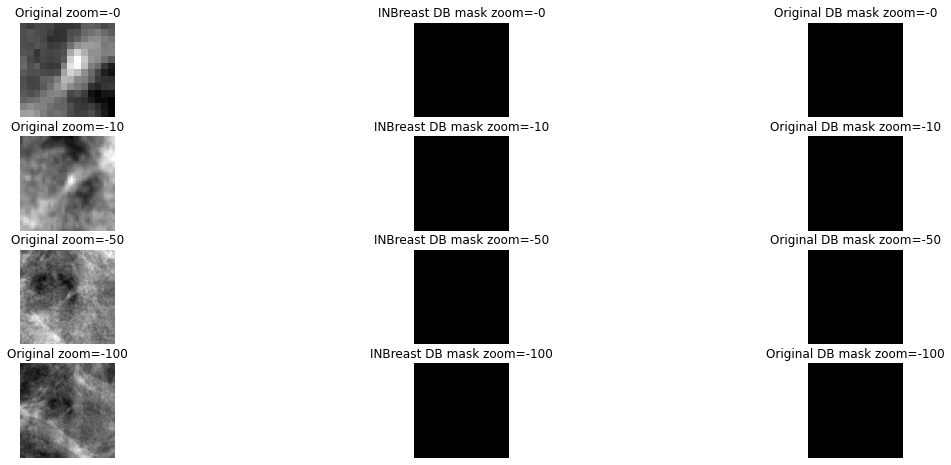

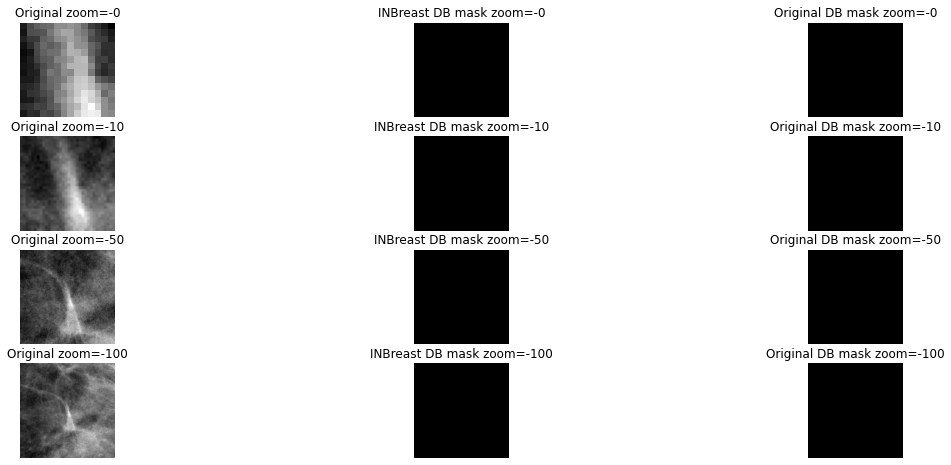

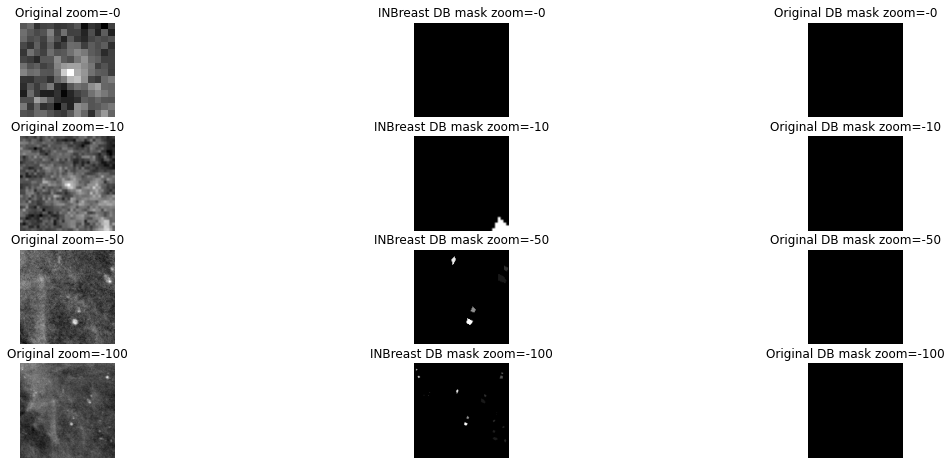

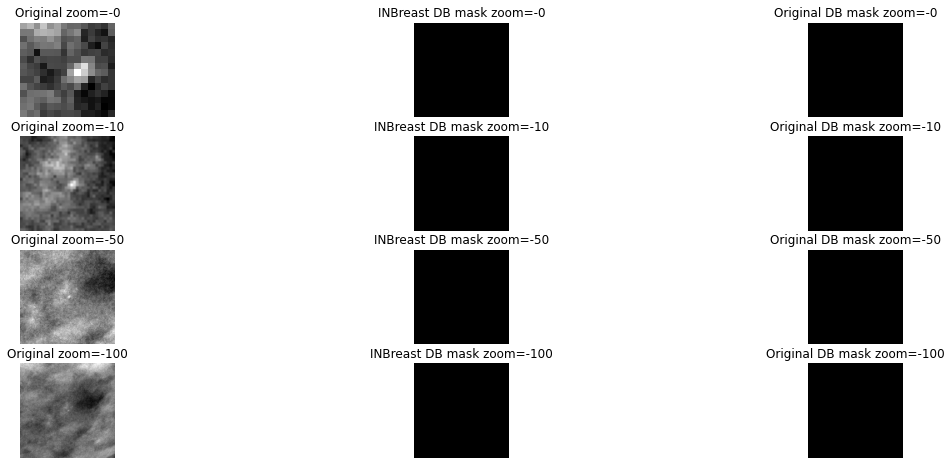

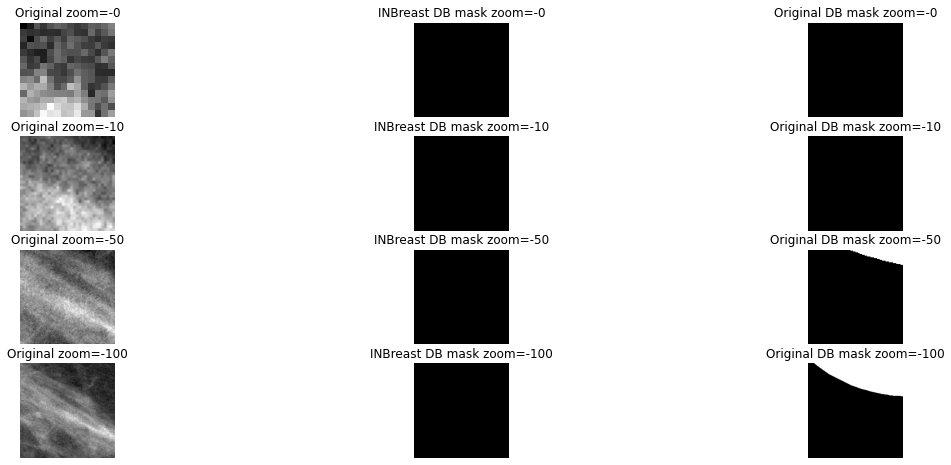

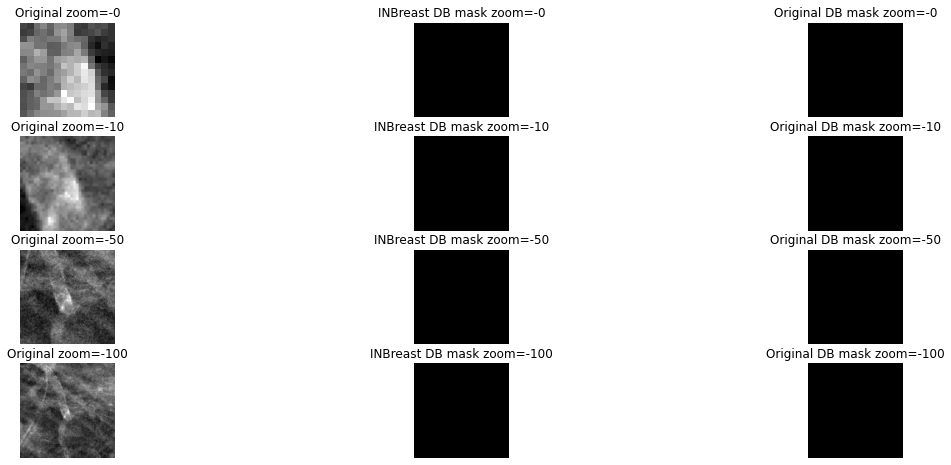

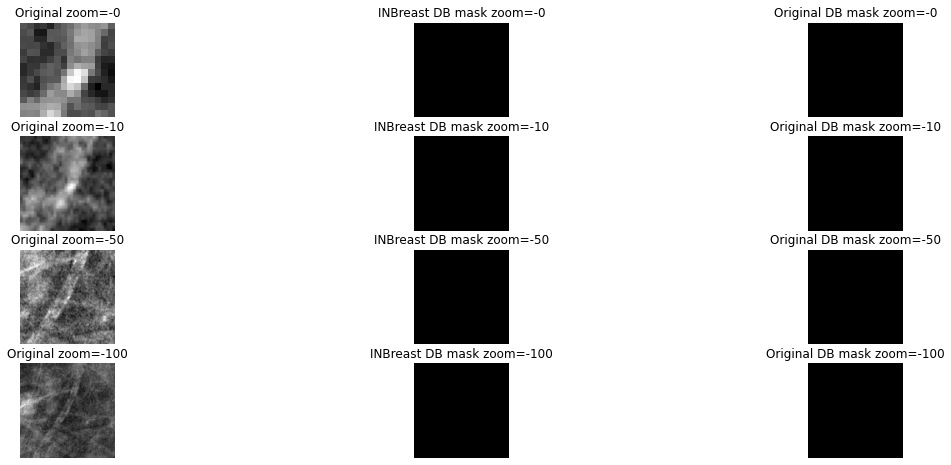

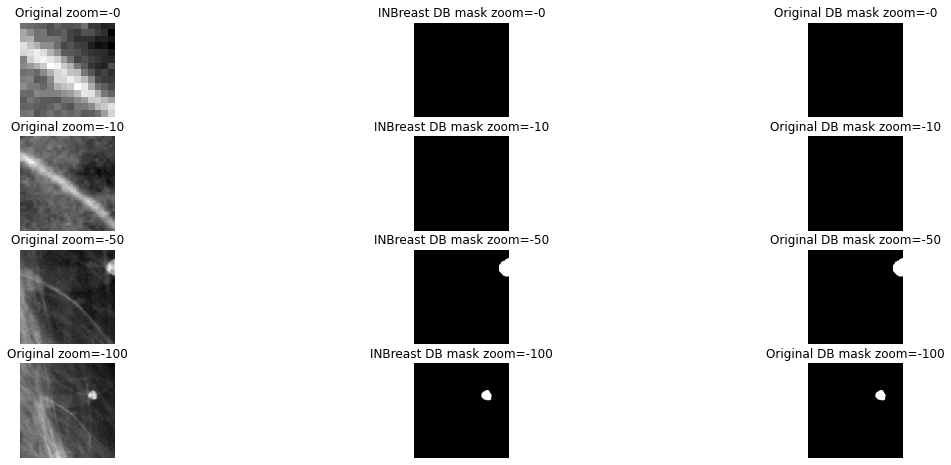

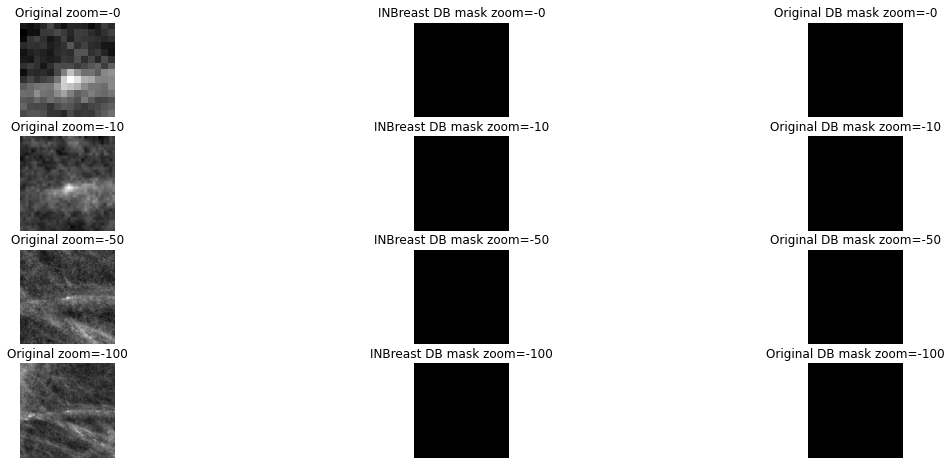

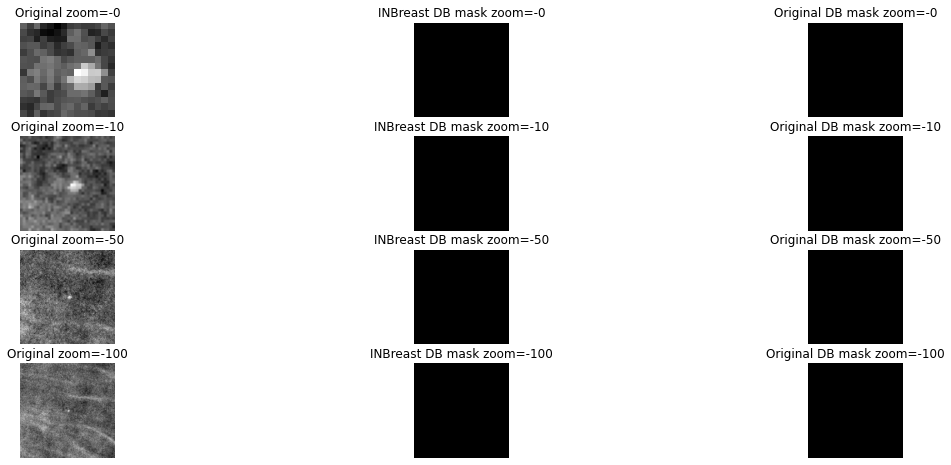

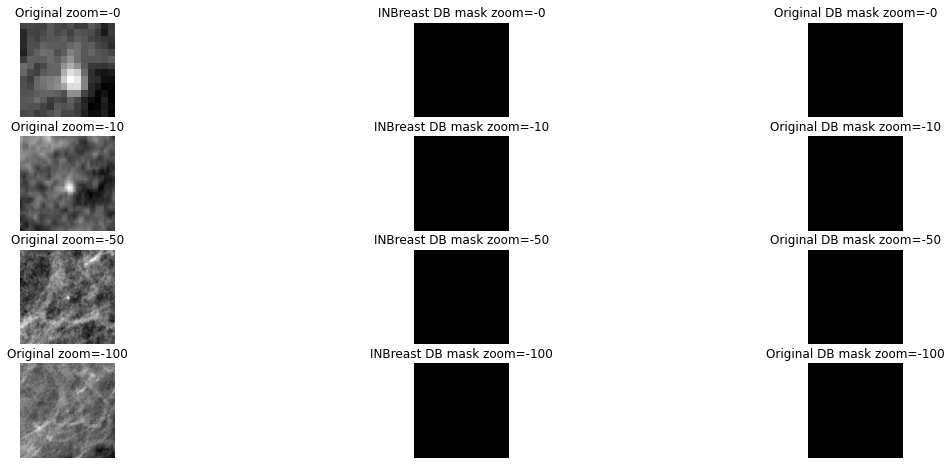

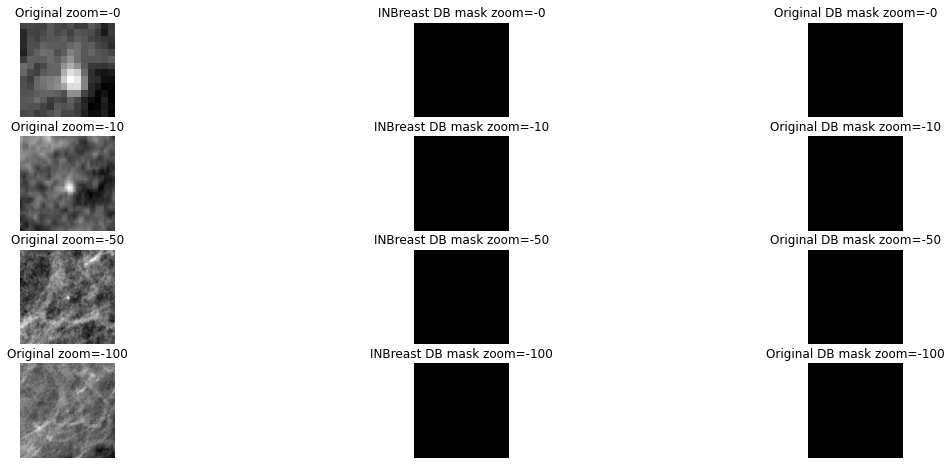

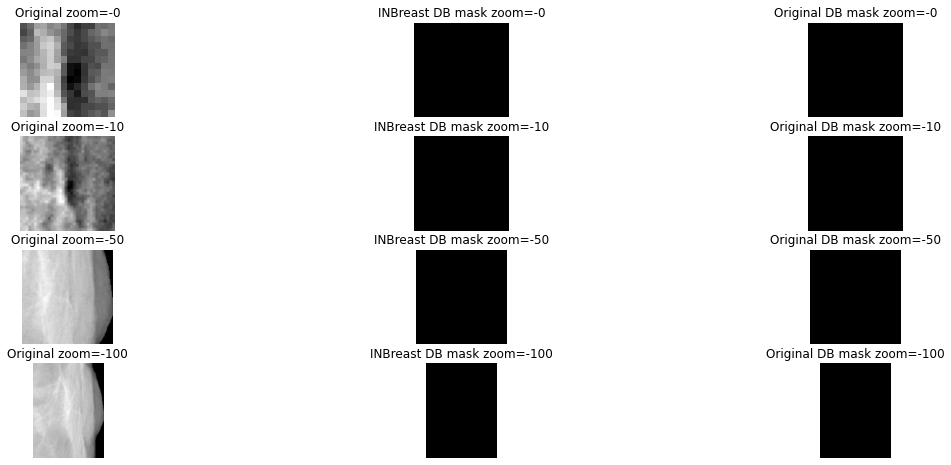

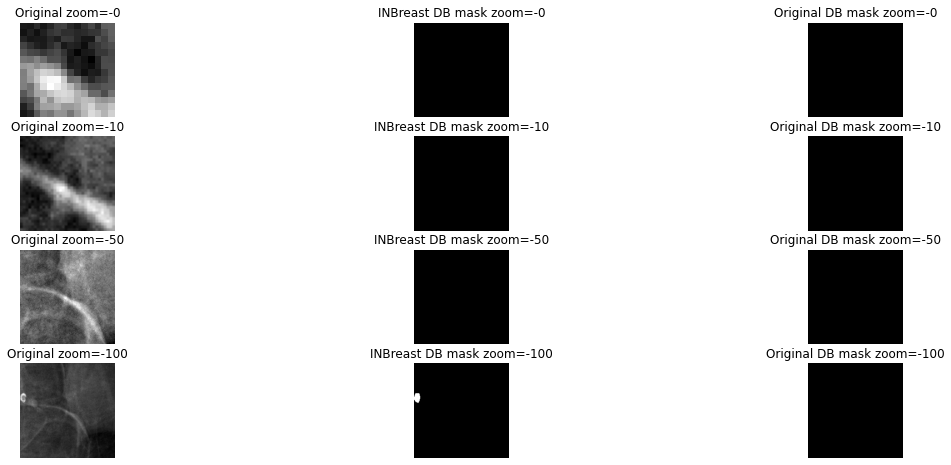

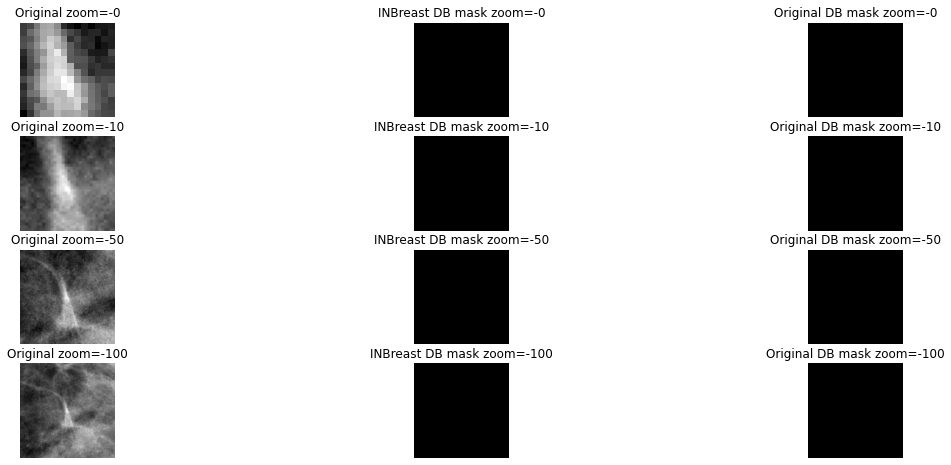

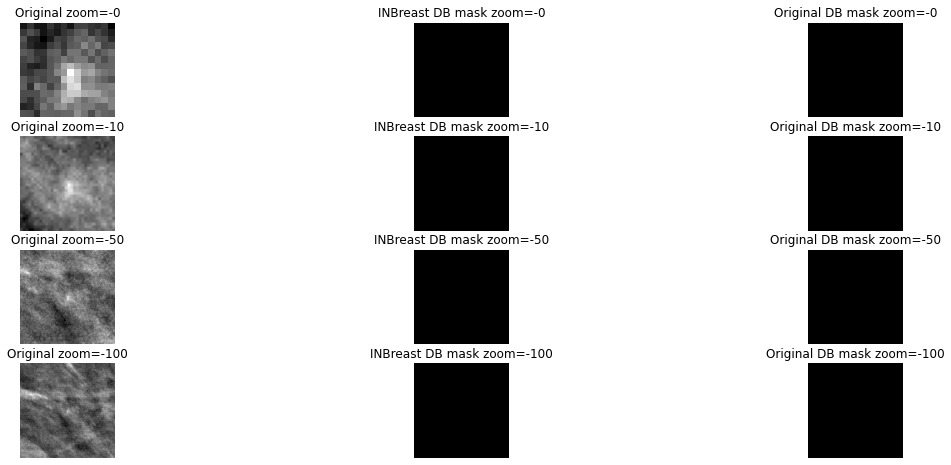

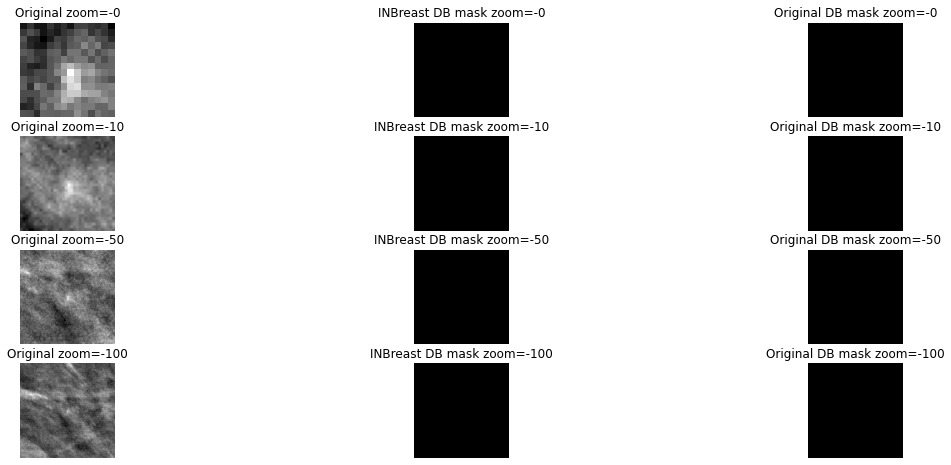

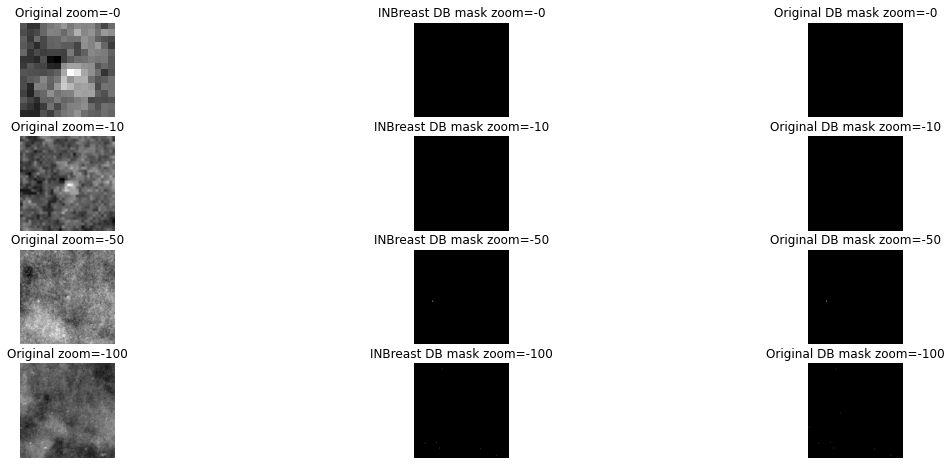

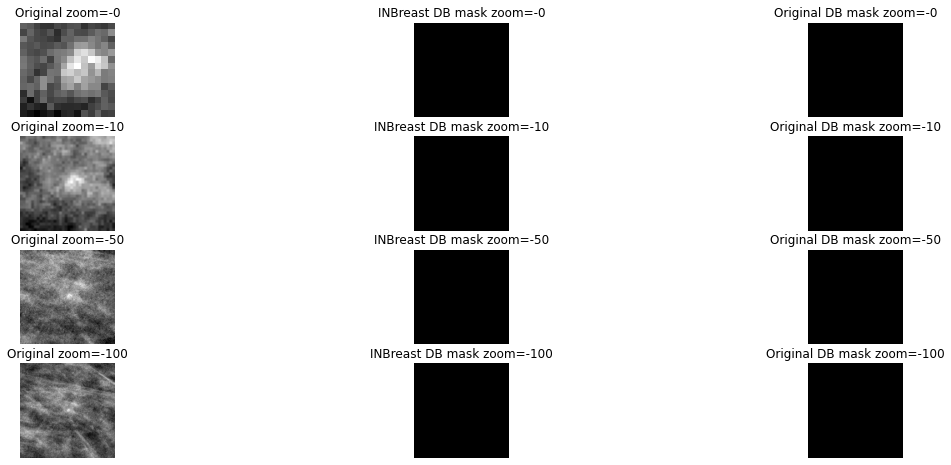

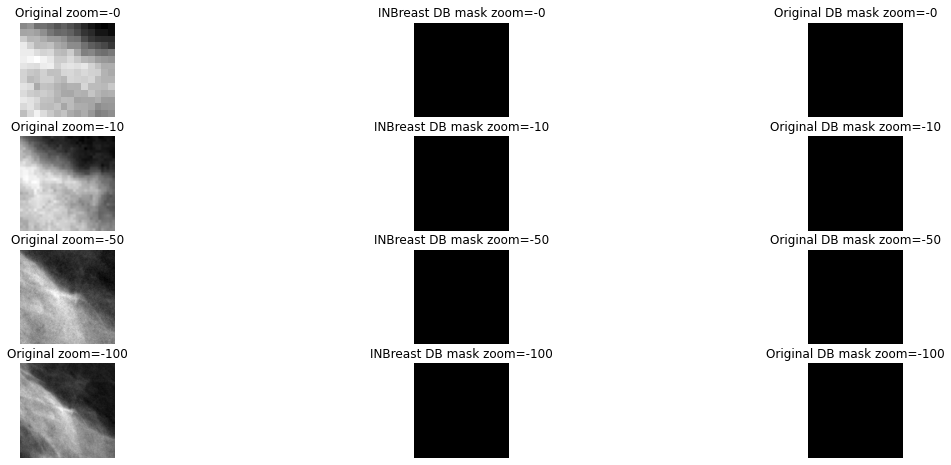

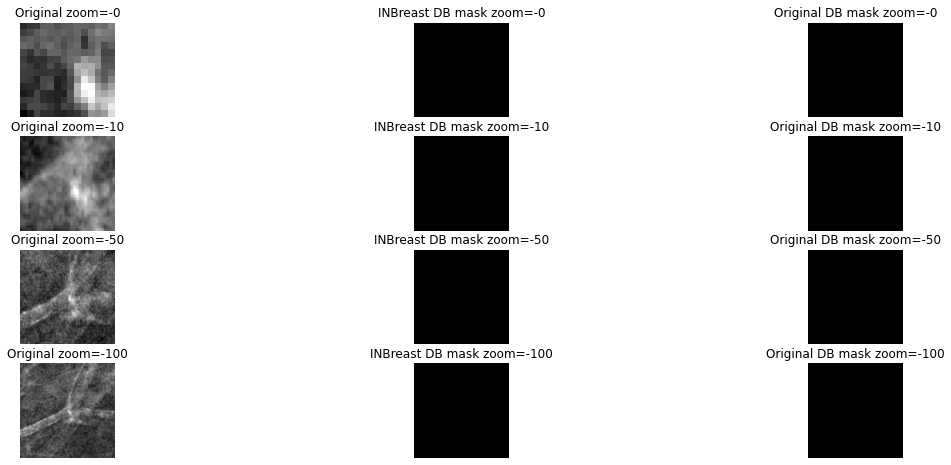

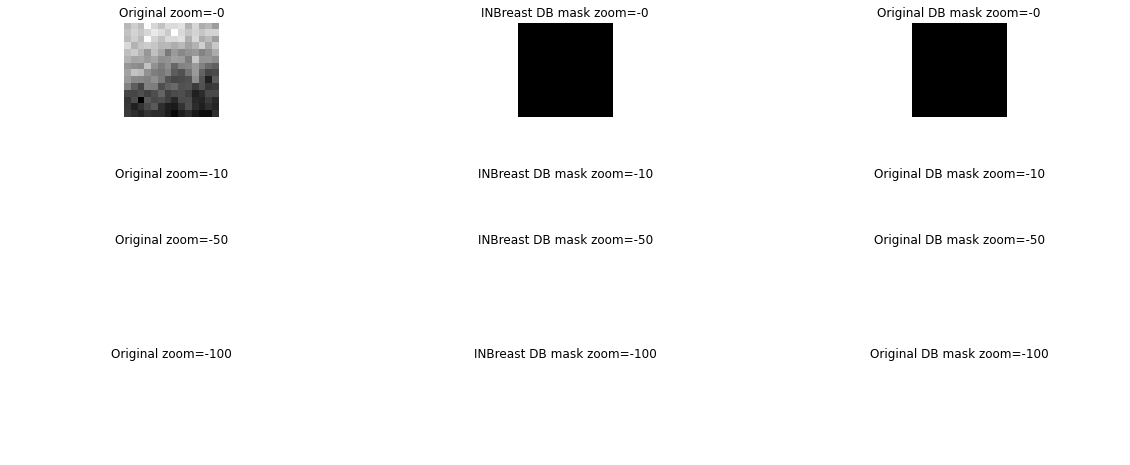

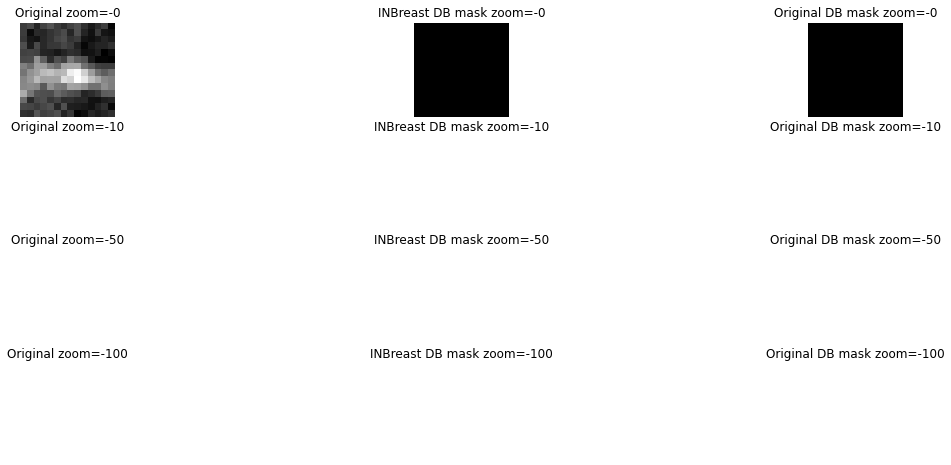

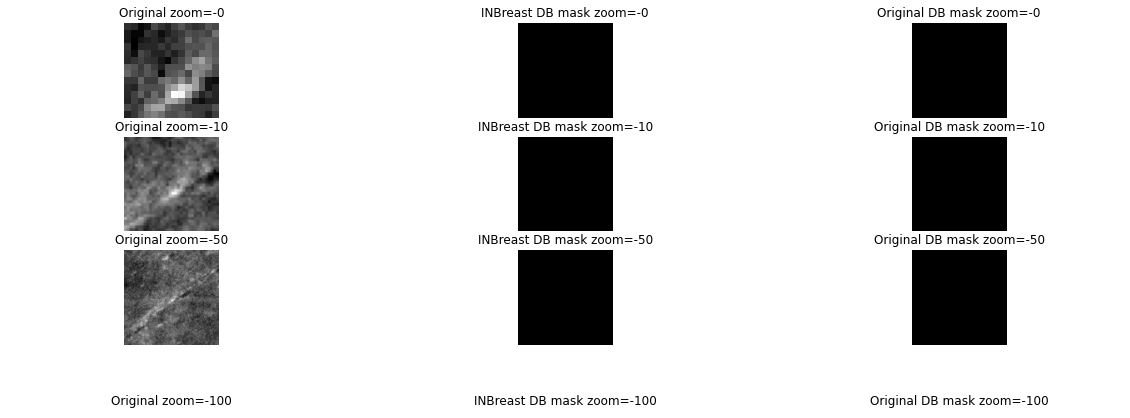

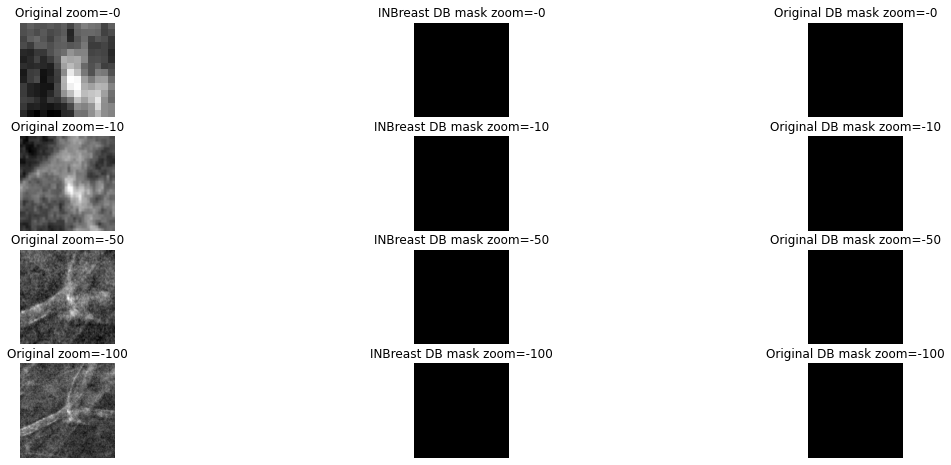

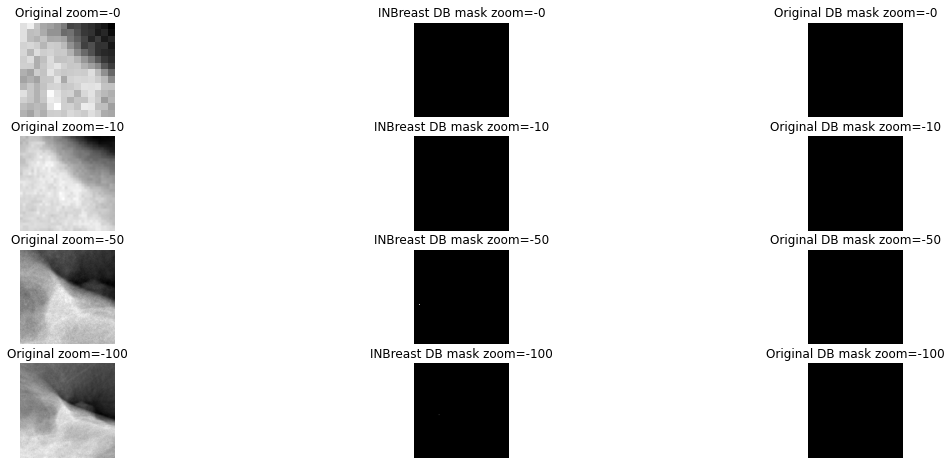

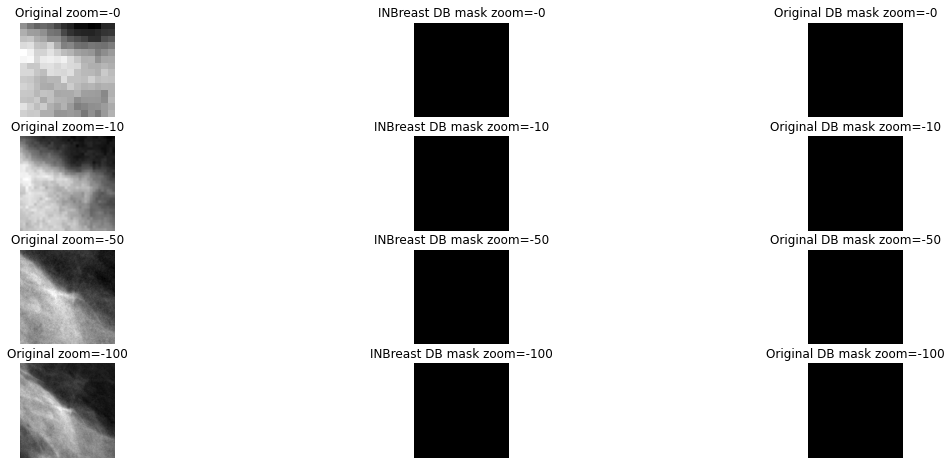

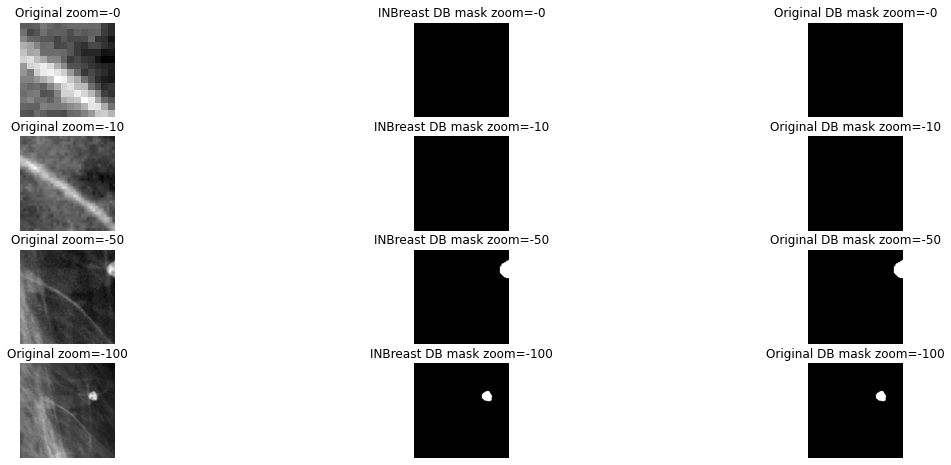

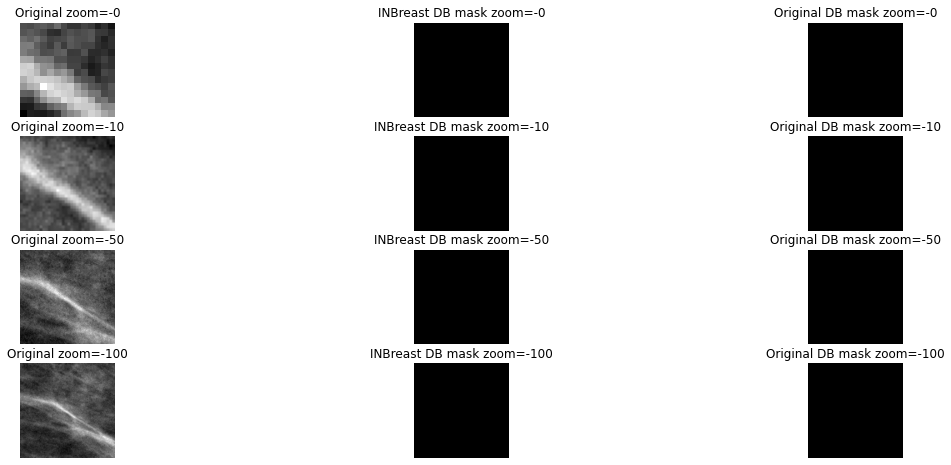

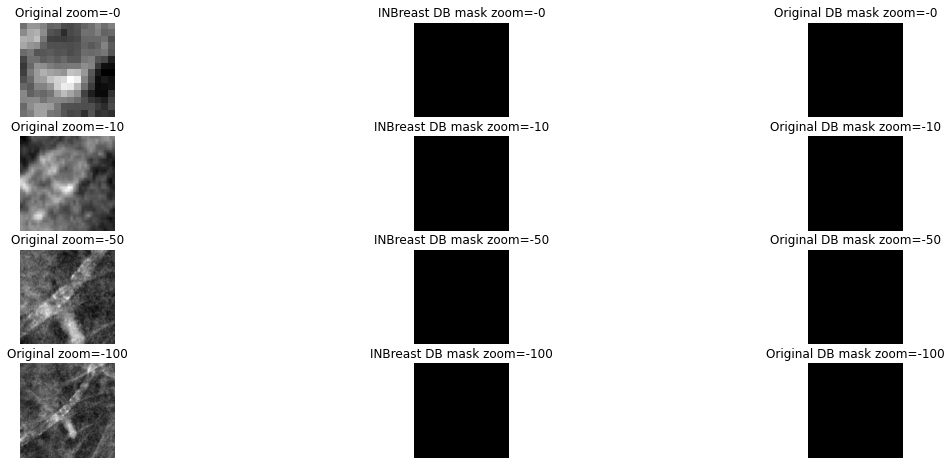

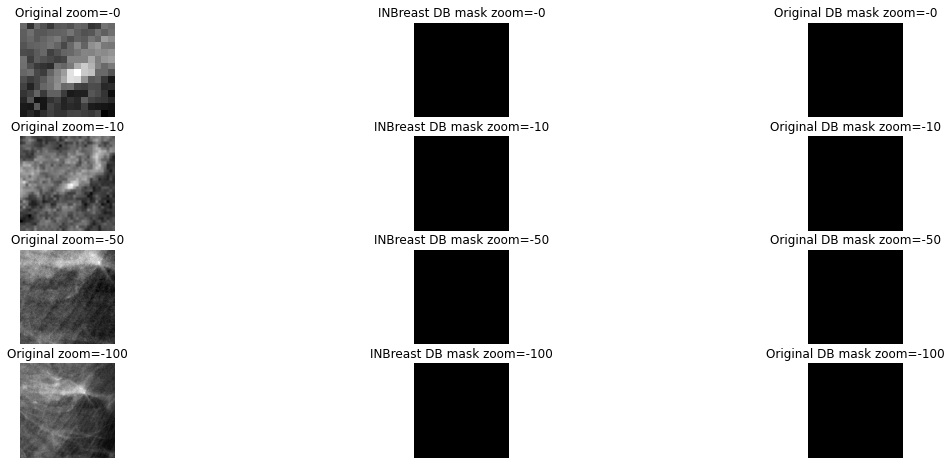

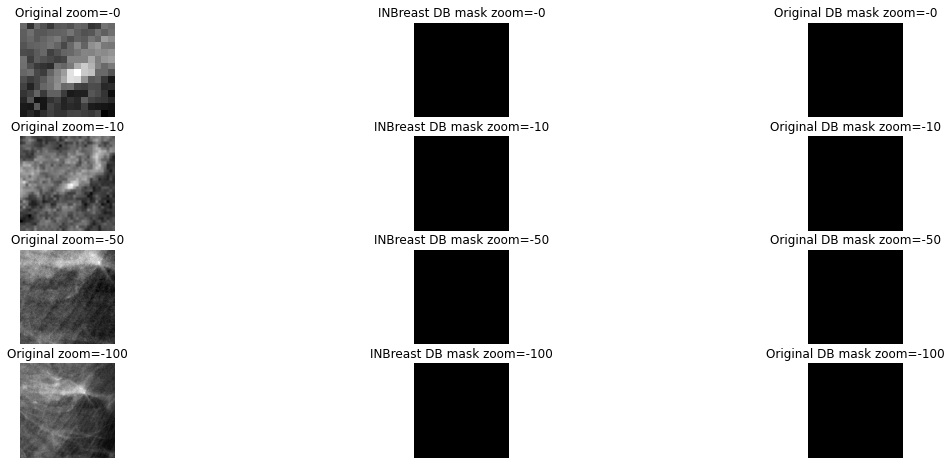

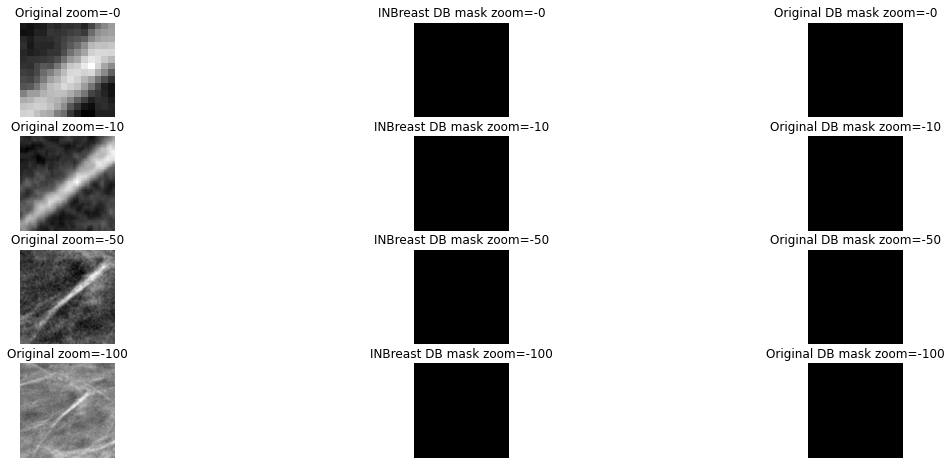

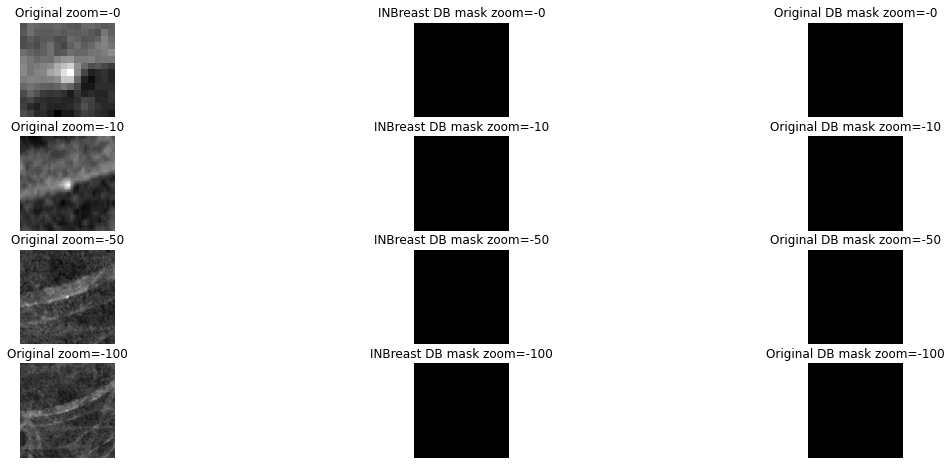

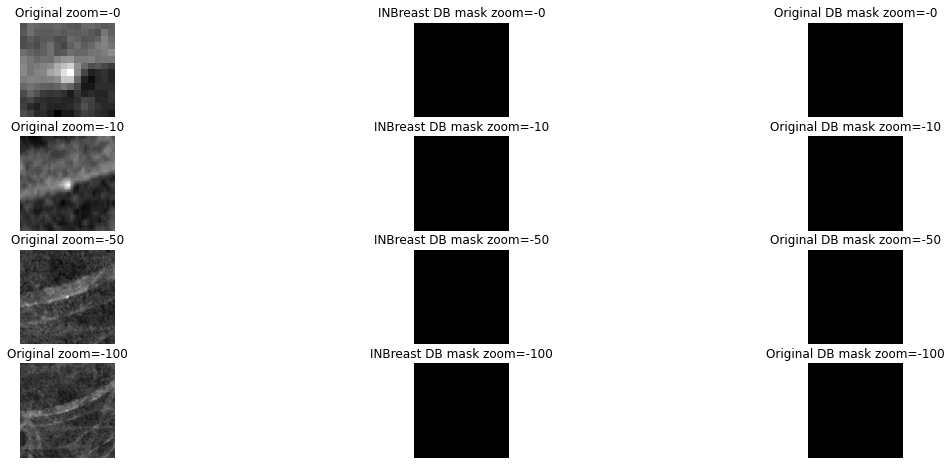

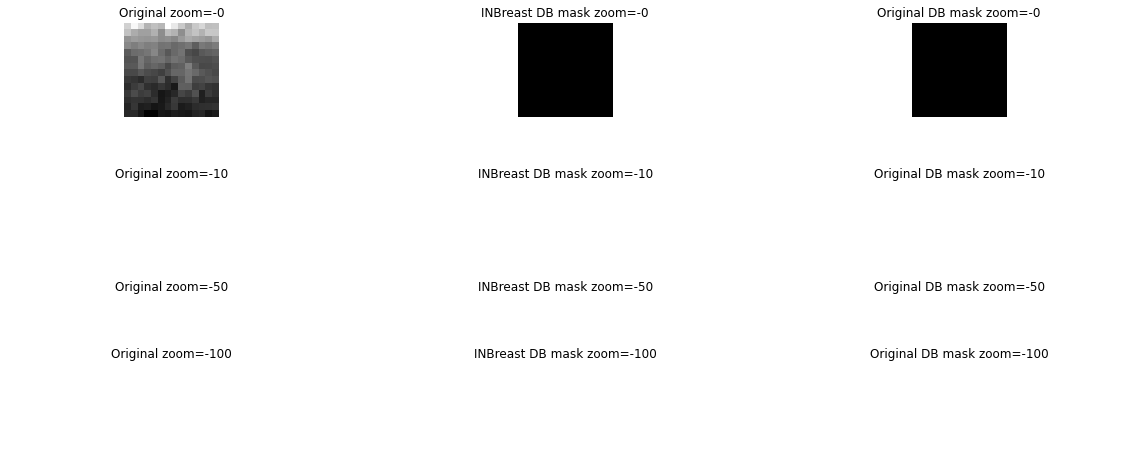

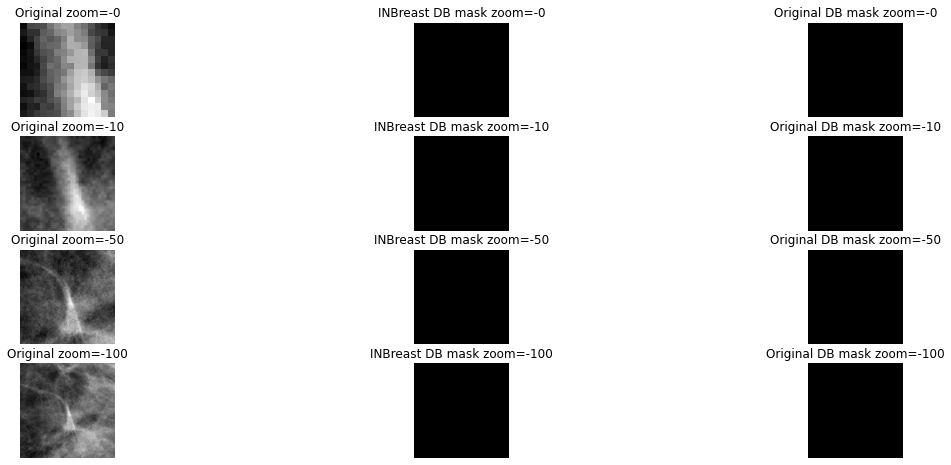

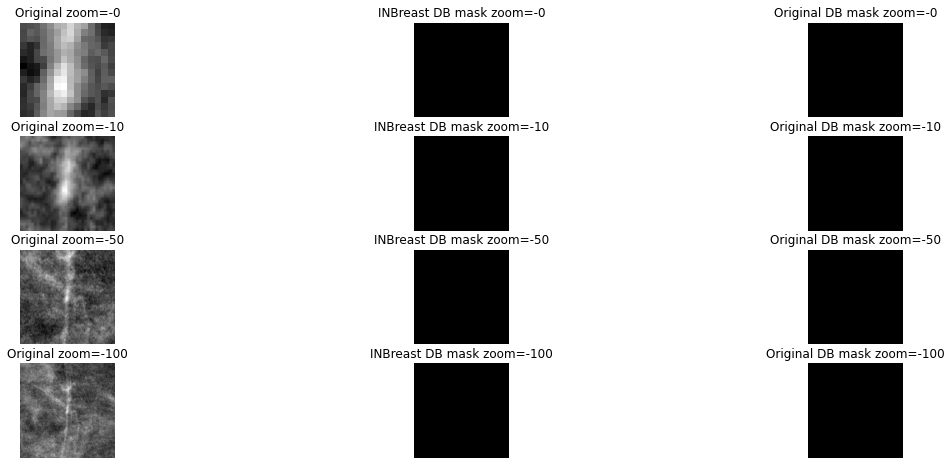

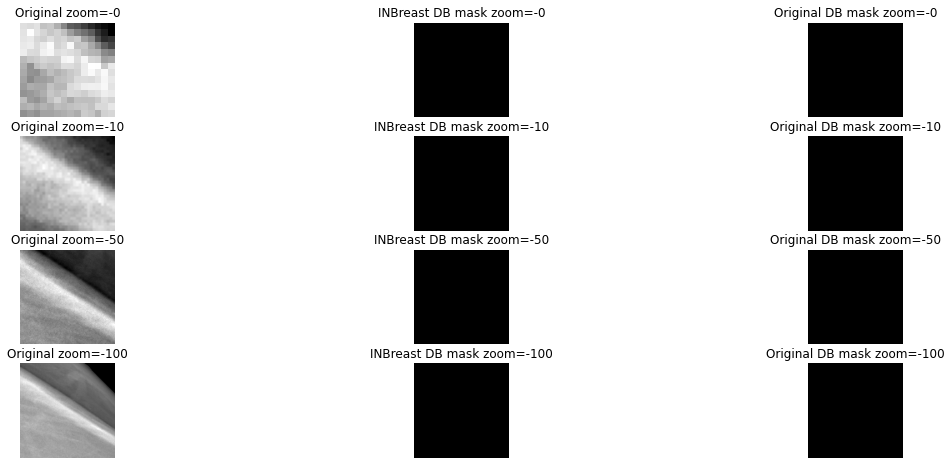

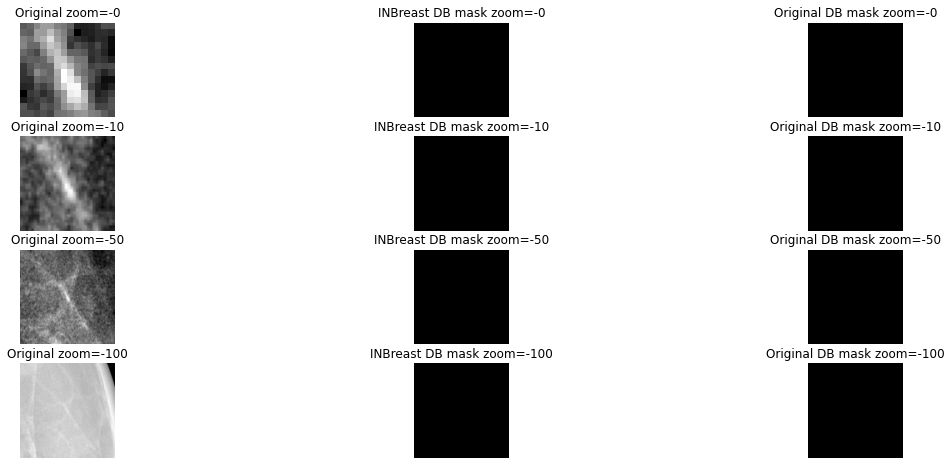

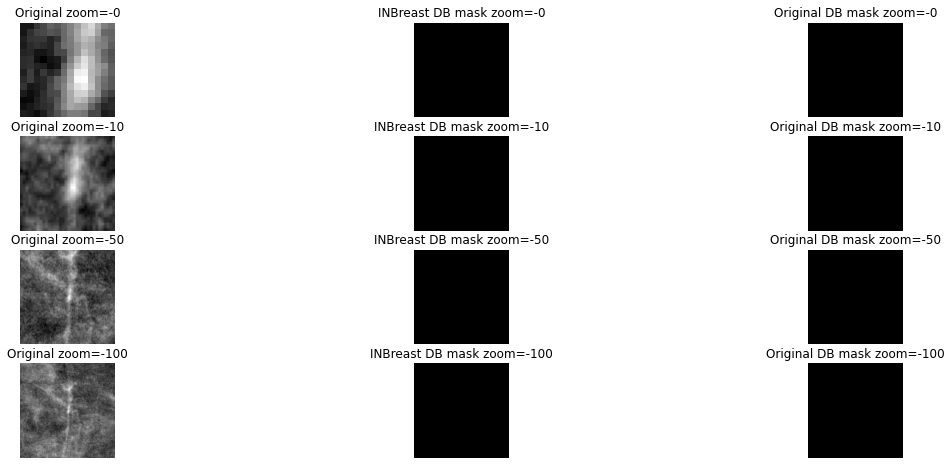

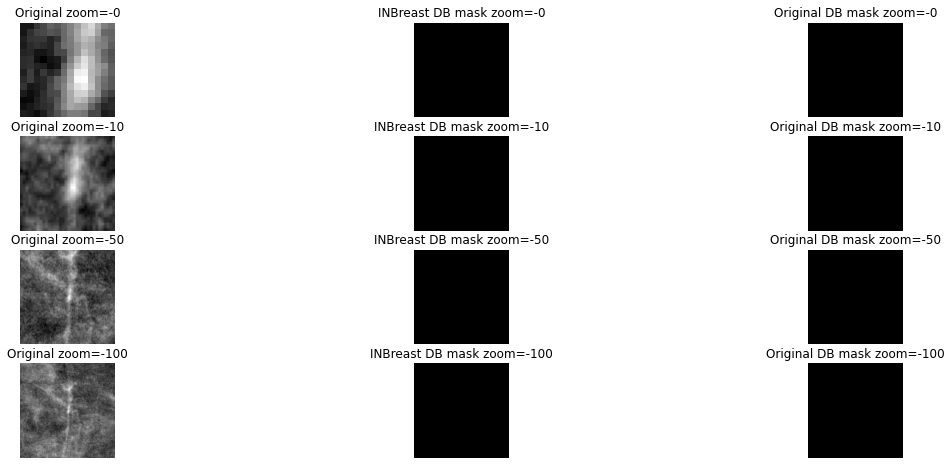

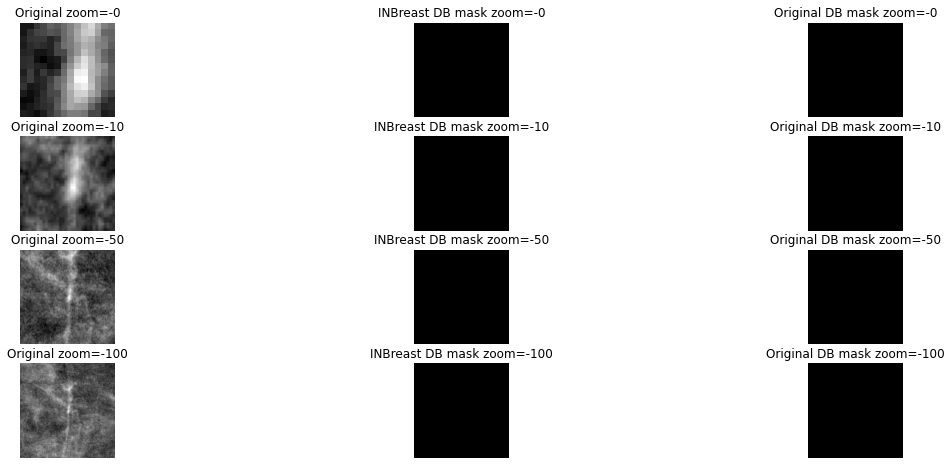

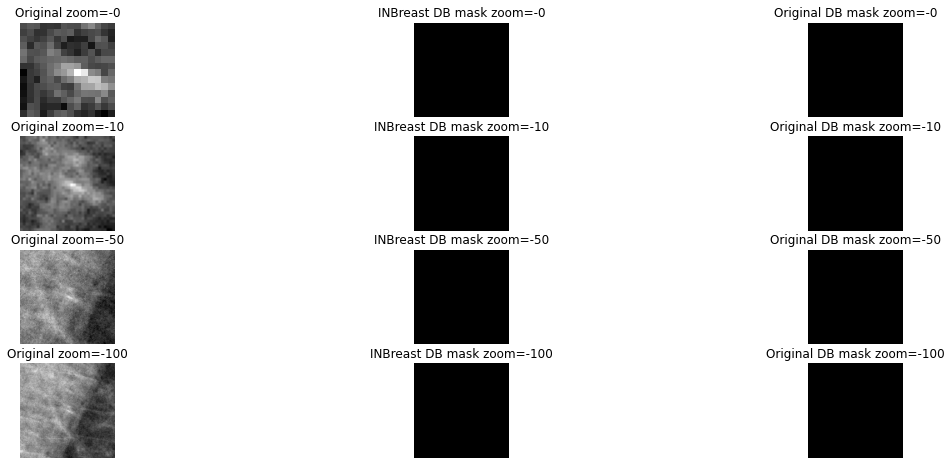

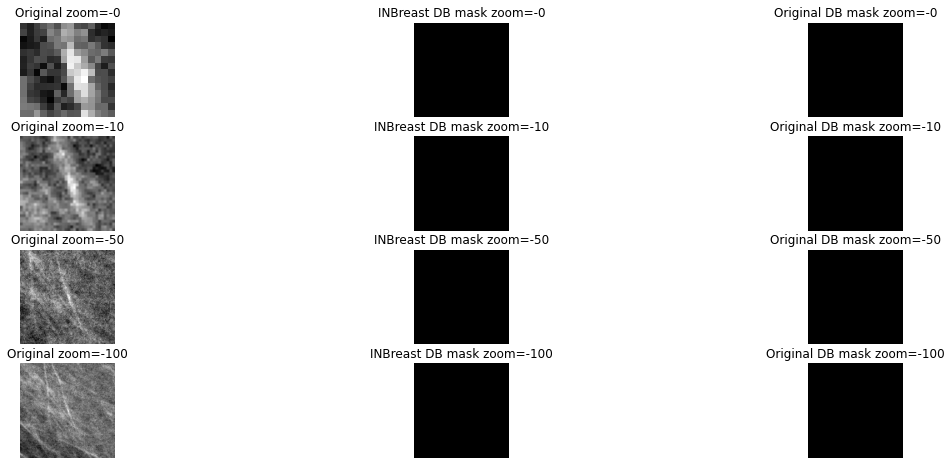

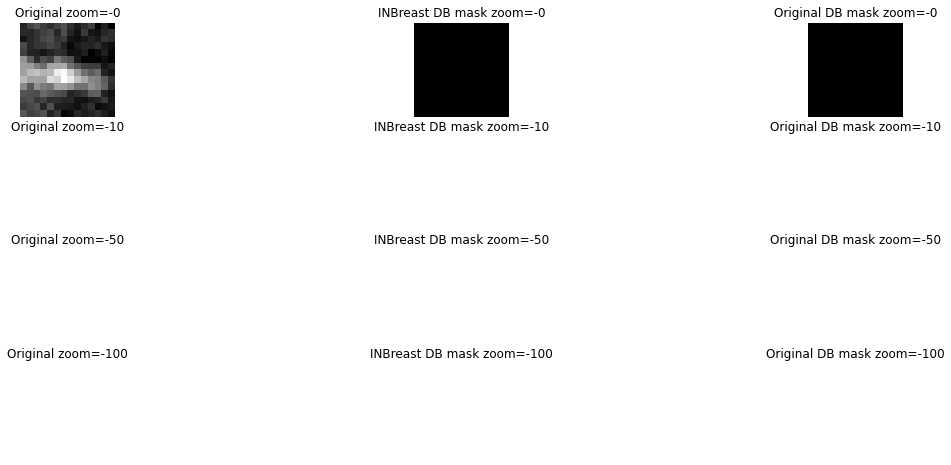

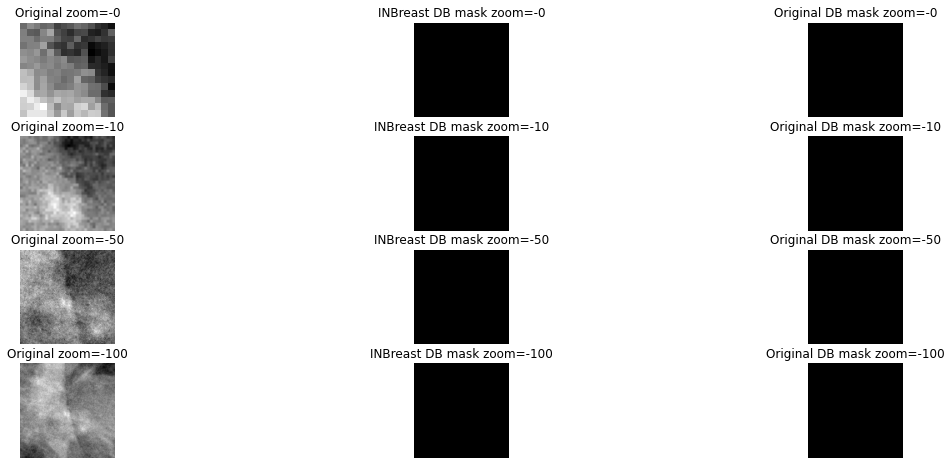

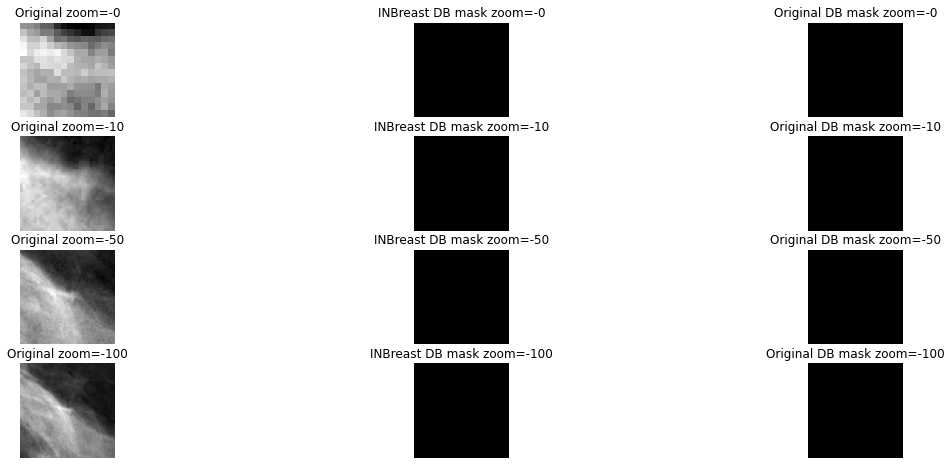

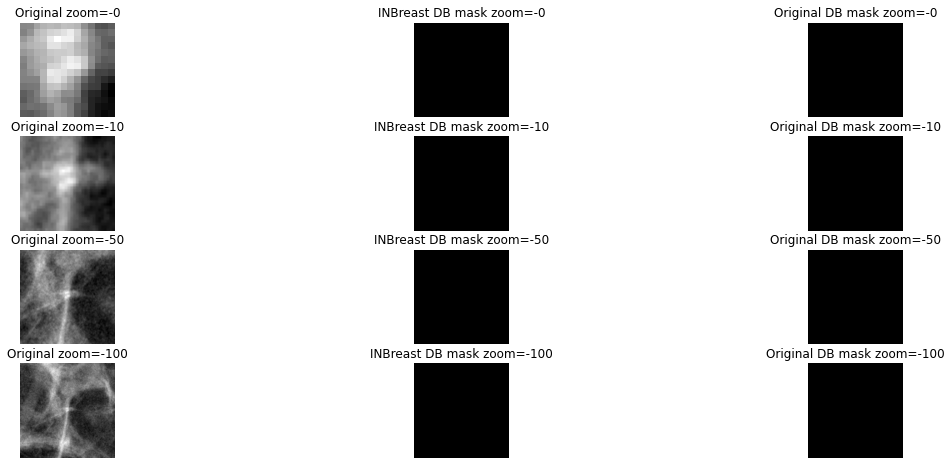

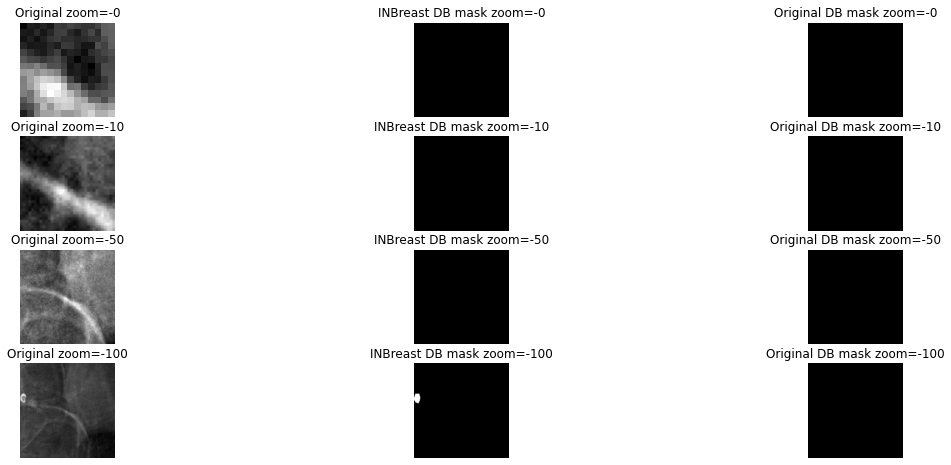

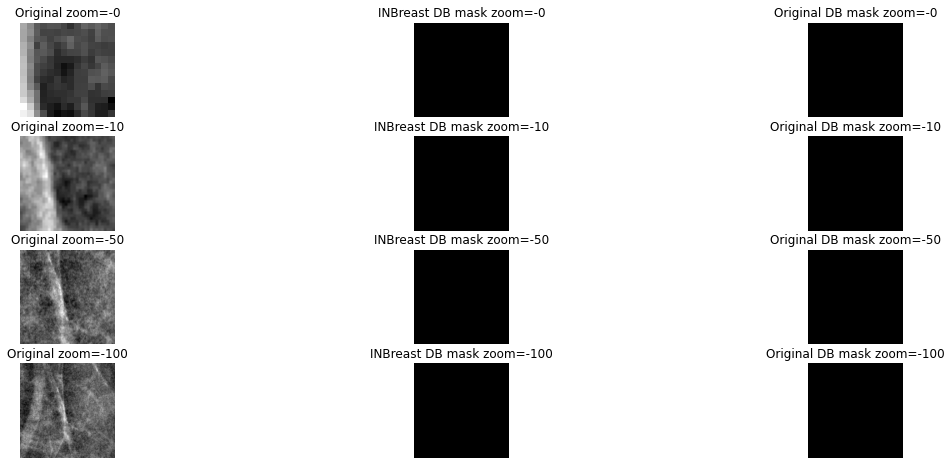

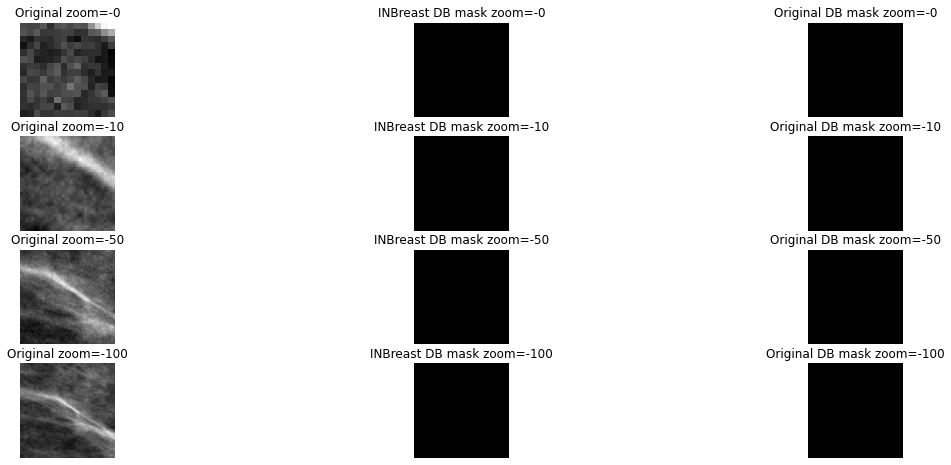

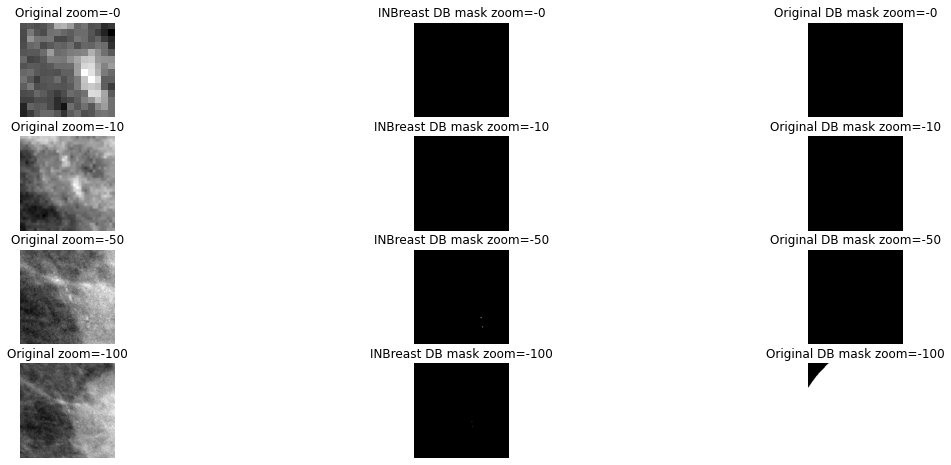

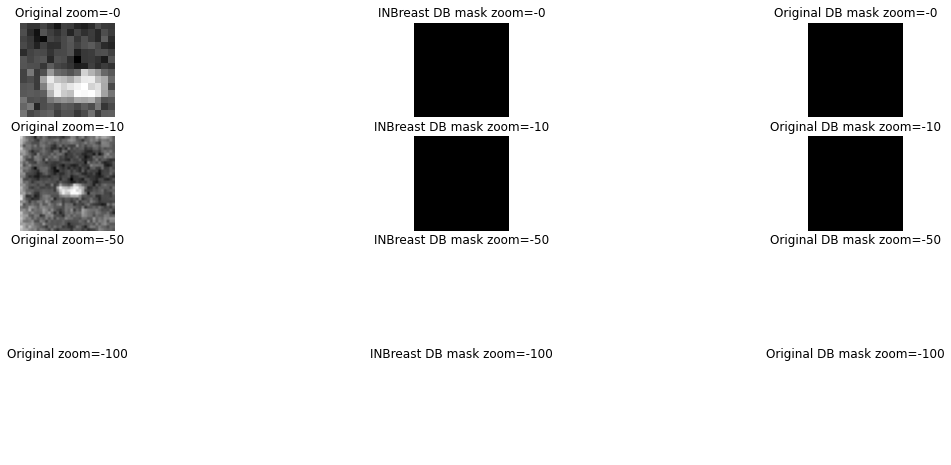

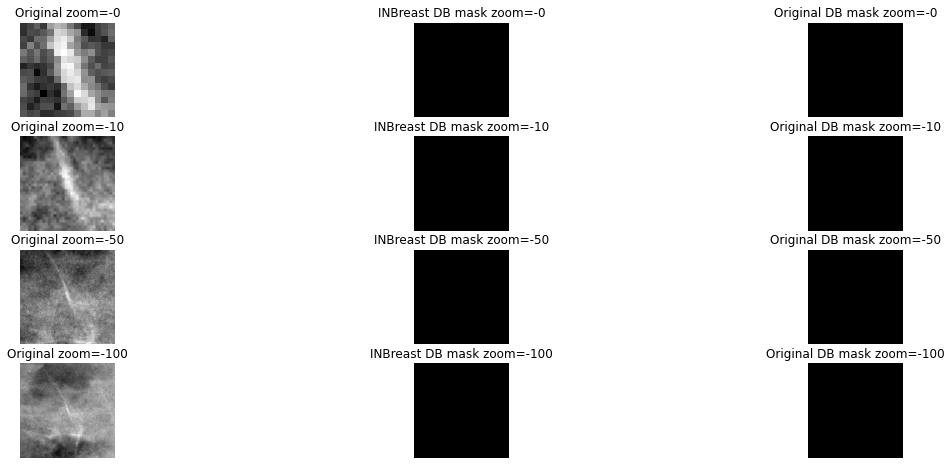

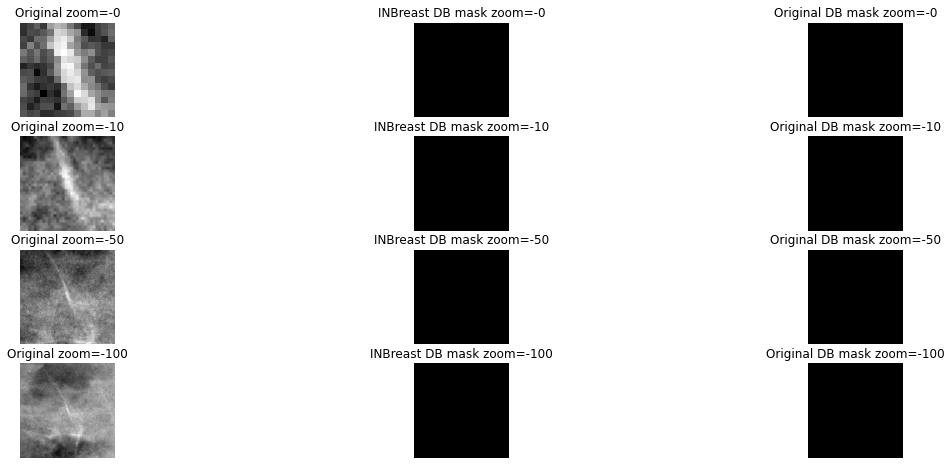

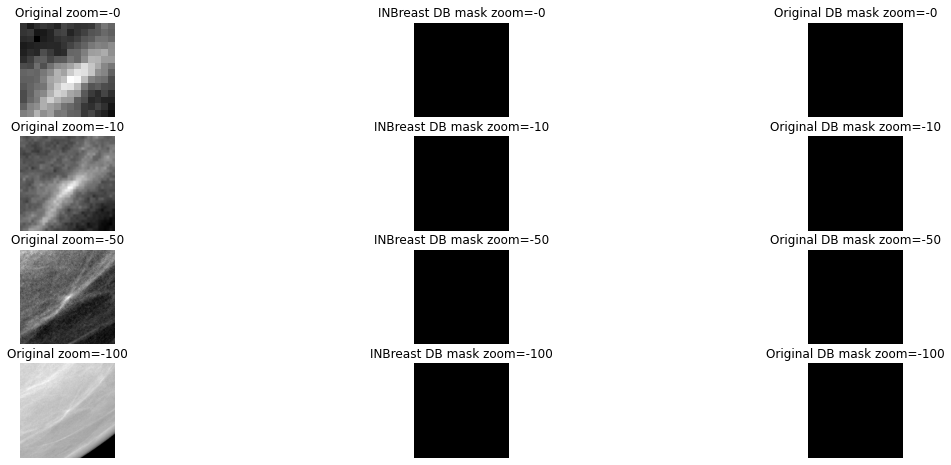

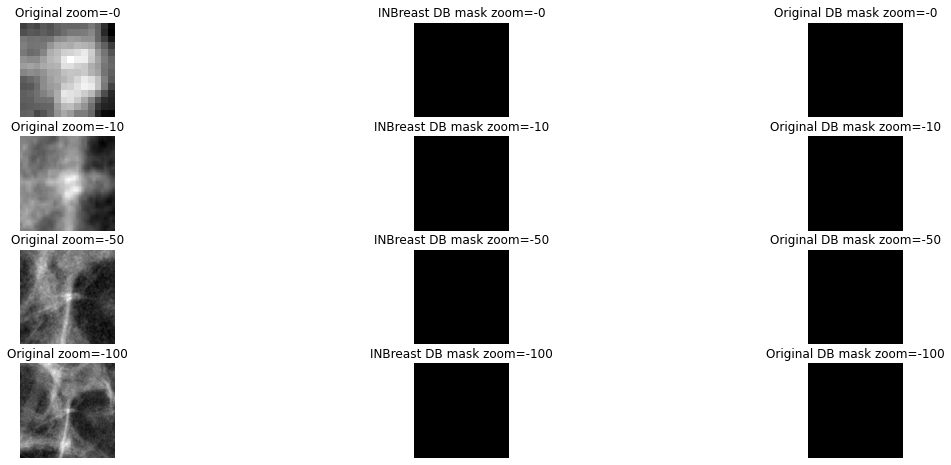

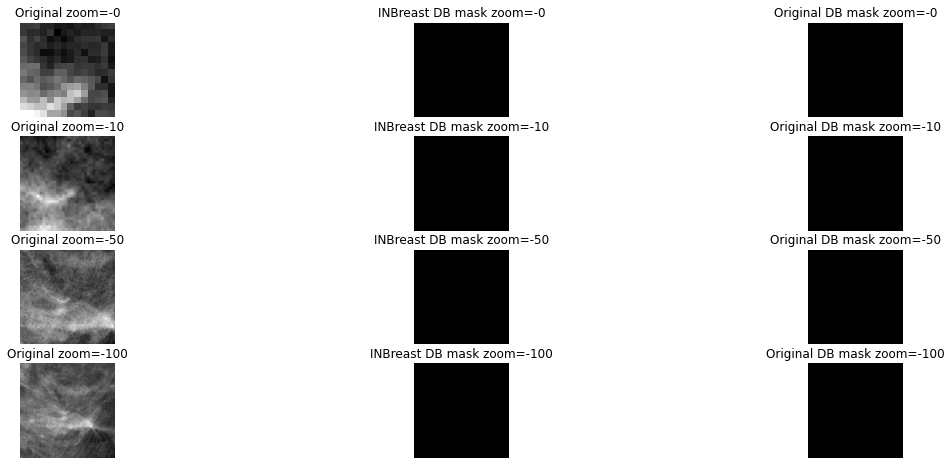

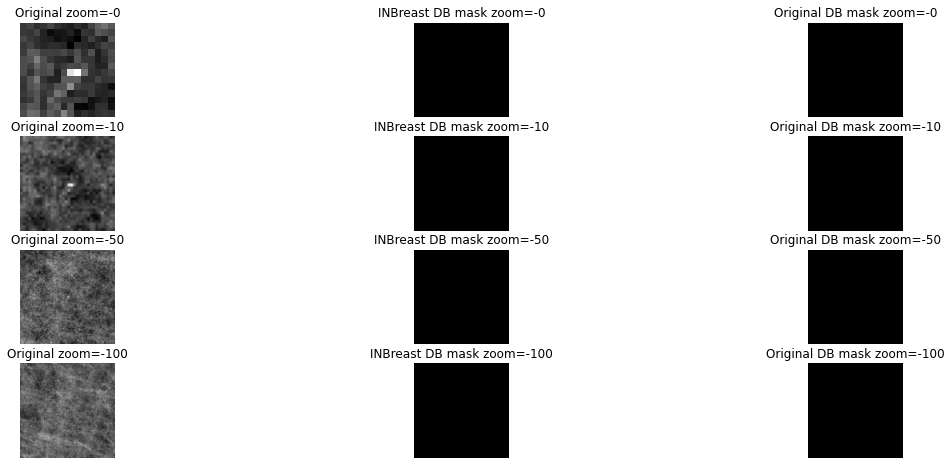

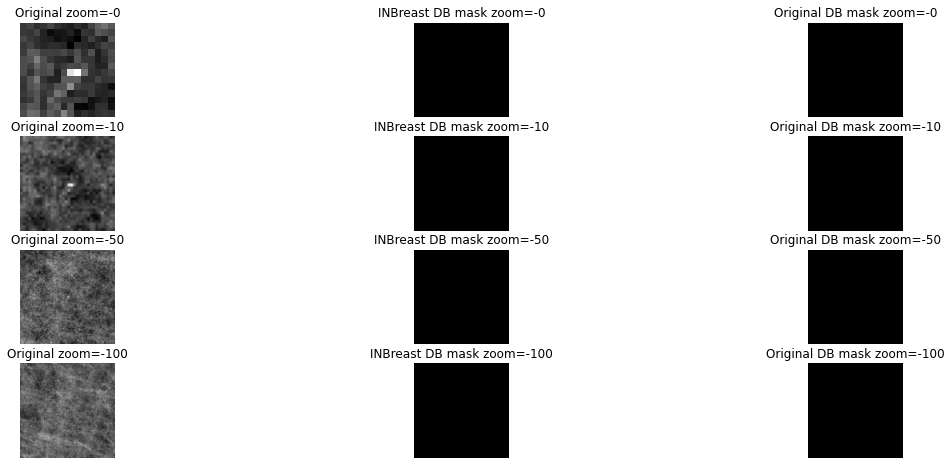

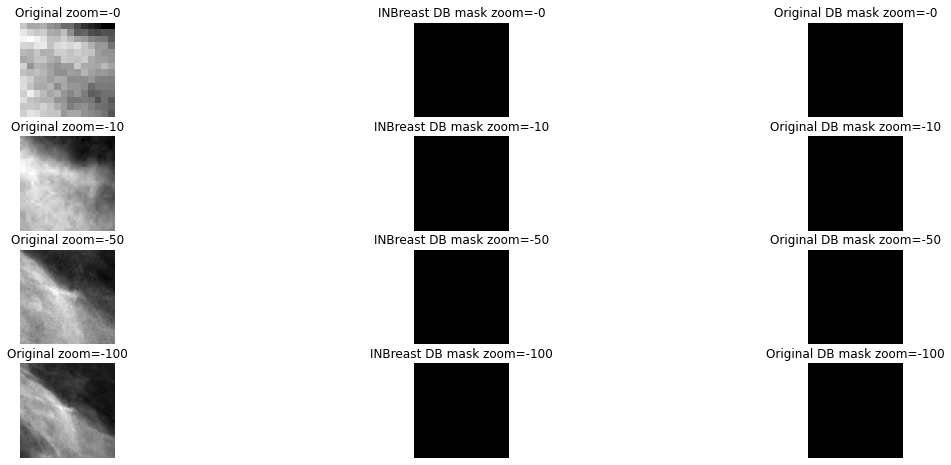

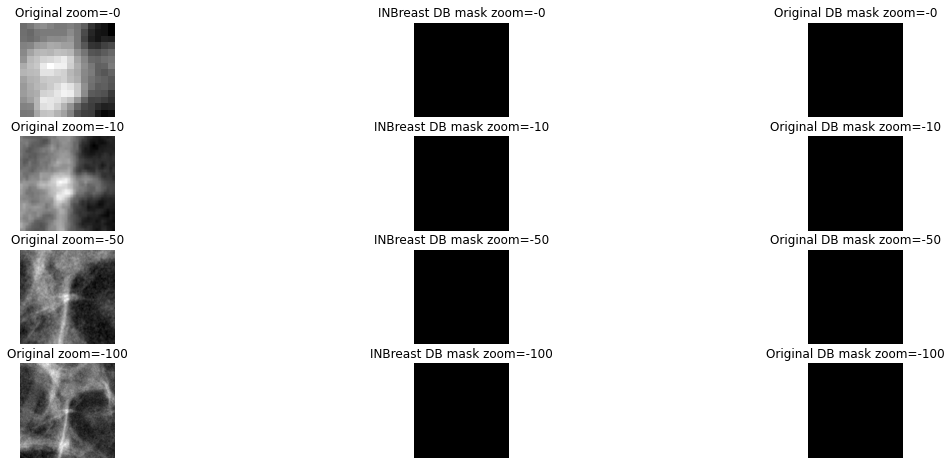

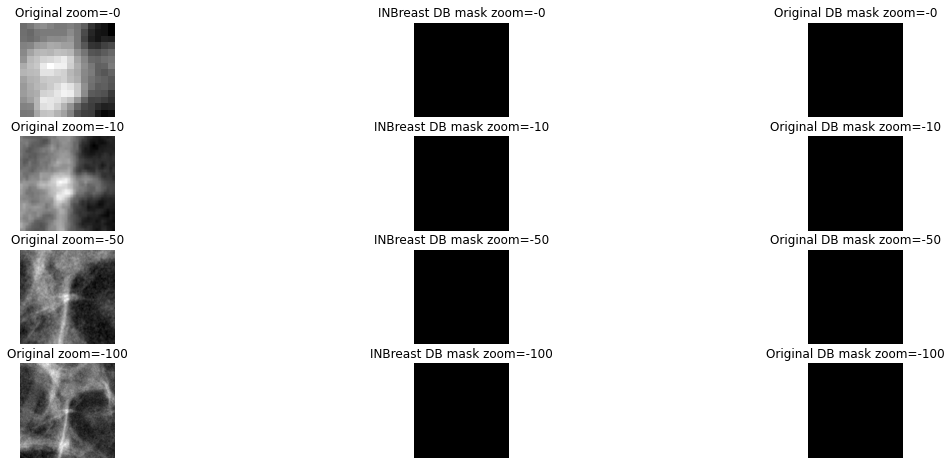

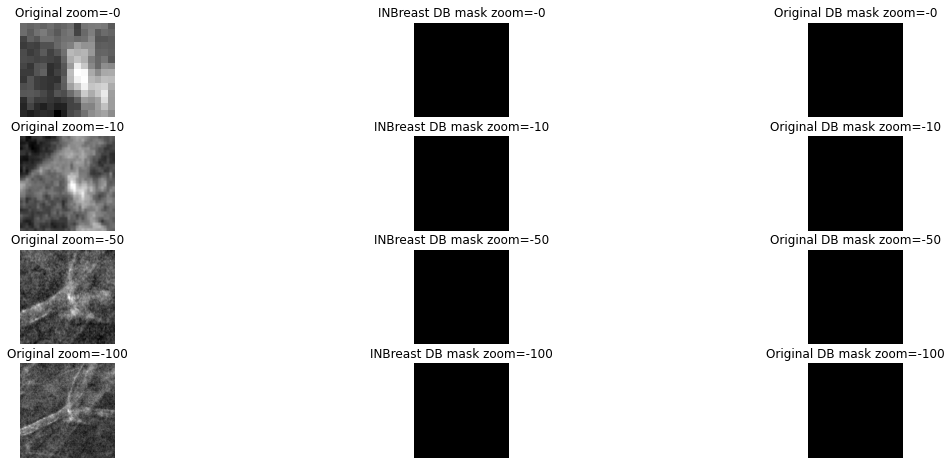

In [34]:

for _, bad_res in tqdm(bad_test_res_df.head(100).iterrows(), total=100):
    img_id = bad_res['img_id']
    test_img_id = db.df[db.df.img_id == img_id].index.values[0] #((2767, 2781), (1029, 1043))	
    test_img = db[test_img_id]['img']
    test_mask = db[test_img_id]['lesion_mask']
    original_test_mask = cv2.imread(str(db.full_mask_path/f'{img_id}_lesion_mask.png'), cv2.IMREAD_GRAYSCALE)
    (ppx1, ppx2), (ppy1, ppy2)= bad_res['patch_coordinates']


    fig, axs = plt.subplots(4,3, figsize=(20, 8))

    for didx, delta in enumerate([0, 10, 50, 100]):
        axs[didx, 0].imshow(test_img[ppx1-delta:ppx2+delta,  ppy1-delta:ppy2+delta], cmap='gray')
        axs[didx, 0].axis('off')
        axs[didx, 0].set_title(f'Original zoom=-{delta}')

        axs[didx, 1].imshow(test_mask[ppx1-delta:ppx2+delta, ppy1-delta:ppy2+delta], cmap='gray')
        axs[didx, 1].axis('off')
        axs[didx, 1].set_title(f'INBreast DB mask zoom=-{delta}')

        axs[didx, 2].imshow(original_test_mask[ppx1-delta:ppx2+delta, ppy1-delta:ppy2+delta]>0, cmap='gray')
        axs[didx, 2].axis('off')
        axs[didx, 2].set_title(f'Original DB mask zoom=-{delta}')
    plt.savefig(f'bad_results/conf={bad_res["confidence"]}_{img_id}_{_}.jpg', bbox_inches="tight", dpi=600, pad_inches=0, transparent=False)